<p> The dataset contains more than 800,000 consumer loans issued from 2007 to 2015 by Lending Club: a large US peer-to-peer lending company. <br> It contains over 75 financial and non-financial variables. <br>Observation window is 12 months. <br><br>Data can be found here: <a href = "https://www.kaggle.com/wendykan/lending-club-loan-data/version/1">Link</a> </p>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid") 

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [3]:
df = pd.read_parquet('loan_data_2007_2014.parquet')

In [4]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Dec-11,Fully Paid,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Dec-11,Charged Off,car,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Dec-11,Fully Paid,small_business,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Dec-11,Fully Paid,other,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Dec-11,Current,other,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<p> Remove all empty columns </p> 

In [5]:
df.dropna(axis=1, how='all', inplace=True)     

<h3> Good / Bad Definition </h3>

<p> NPL = 30+ dpd </p>

In [6]:
# 1 means defaulted, 0 means non-default

df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',  'Does not meet the credit policy. Status:Charged Off']), 1 , 0)
df[['good_bad', 'loan_status']]

,good_bad,loan_status
0,0,Fully Paid
1,1,Charged Off
2,0,Fully Paid
3,0,Fully Paid
4,0,Current
...,...,...
466280,0,Current
466281,1,Charged Off
466282,0,Current
466283,0,Fully Paid


<h3> Bad Rate </h3>

<p> Highly imbalanced dataset </p>

0    0.890693
1    0.109307
Name: good_bad, dtype: float64


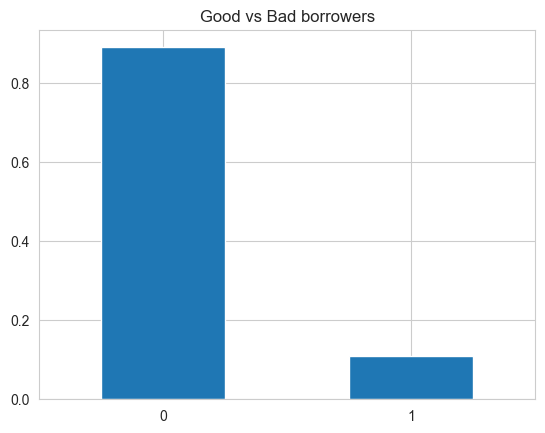

In [7]:
results = df['good_bad'].value_counts() / len(df['good_bad'])        

results.plot.bar(rot=0, title="Good vs Bad borrowers");
print(results)

<h3> Pre-processing of  'Months Since Issue Date' </h3>

In [8]:
#pre-processing strings to int

df['emp_length_int'] = df['emp_length'].str.replace(' year', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('s', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('+', '')
df['emp_length_int'] = df['emp_length_int'].str.replace('< 1', '0')

df['emp_length_int'] = pd.to_numeric(df['emp_length_int'])

C:\Users\ngchi\AppData\Local\Temp\ipykernel_13724\3208970195.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['emp_length_int'] = df['emp_length_int'].str.replace('+', '')


In [9]:
#pre-processing strings to int

df['term_int'] = df['term'].str.replace(' months', '')
df['term_int'] = df['term_int'].str.strip()

df['term_int'] = pd.to_numeric(df['term_int'])

In [10]:
df = df.dropna(subset = ['earliest_cr_line'])

In [11]:
#reading in cr line date. When we convert to datetime, those with 60s get misinterpreted as 2060s instead of 1960s. 
#anything with the %y year below 69 will be attributed a century of 2000, and 69 upwards get 1900

list_a = list()

for i in df['earliest_cr_line']:
    
    if (23 <= float(i[-2:]) < 69):
        
        i = list(i)
        i.insert(4, '1')
        i.insert(5, '9')
        
        i = "".join(i)       #convert list back to string
    
    elif (0 <= float(i[-2:]) < 23): 
        
        i = list(i)
        i.insert(4, '2')
        i.insert(5, '0')
        
        i = "".join(i)
        
    else:
        
        i = list(i)
        i.insert(4, '1')
        i.insert(5, '9')
        
        i = "".join(i)   
        
    list_a.append(i)

In [12]:
df['earliest_cr_line'] = list_a

In [13]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%Y')
df['months_since_earliest_cr_line'] = round((pd.to_datetime('2017-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1, 'M'))

In [14]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')
df['mths_since_issue_d'] = round((pd.to_datetime('2017-12-01') - df['issue_d_date']) / np.timedelta64(1, 'M'))

<h3> Missing treatment </h3>

In [15]:
df['total_rev_hi_lim'].fillna(df['funded_amnt'], inplace=True)
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)

<H3> Feature Engineering using WoE and IV </H3>

<h4> Fine-CLassing via Weight of Evidence (WoE) together with Coarse-Classing (if applicable)</h4>

<p> Discrete / Categorical Variable </p>

In [16]:
def woe_discrete(categorical_var):
    
    WoE_results = pd.DataFrame()

    WoE_results[categorical_var] = df[categorical_var]
    WoE_results['Good_Bad'] = df['good_bad']

    Count = WoE_results.groupby([categorical_var]).count().reset_index()
    Mean = WoE_results.groupby([categorical_var]).mean().reset_index()

    df1 = pd.concat([Count, Mean], axis = 1)
    df1 = df1.iloc[:,[0,1,3]]

    df1.columns = [categorical_var, 'n_obs', 'prop_bad']

    df1['prop_good'] = 1 - df1['prop_bad']

    df1['n_bad'] = df1['prop_bad'] * df1['n_obs']
    df1['n_good'] = df1['prop_good'] * df1['n_obs']

    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()

    df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])

    df1['%Good - %Bad'] = df1['prop_n_good'] - df1['prop_n_bad'] 

    df1['IV'] = df1['WoE'] * df1['%Good - %Bad']

    df1['IV'] = np.where(df1['IV'] == np.inf, 0, df1['IV'])  # Replace infinite values with 0
    
    df1.IV = df1.IV.sum()
    
    df1.sort_values(by='WoE', inplace = True)

    return df1

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()                                

def plot_by_woe(df, rotation_of_x_axis_labels = 0):
    x = np.array(df.iloc[:, 0].apply(str))               #matplotlib works better with numpy and scipy
    y = df['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

<h4> For 'Grade' - Keep </h4>

In [18]:
woe_discrete('grade')

,grade,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
6,G,3322,0.278146,0.721854,924.0,2398.0,0.018130,0.005774,-1.144162,-0.012356,0.290812
5,F,13229,0.241288,0.758712,3192.0,10037.0,0.062631,0.024169,-0.952210,-0.038463,0.290812
4,E,35756,0.194765,0.805235,6964.0,28792.0,0.136643,0.069330,-0.678497,-0.067313,0.290812
3,D,76887,0.154083,0.845917,11847.0,65040.0,0.232454,0.156613,-0.394913,-0.075841,0.290812
2,C,125287,0.114808,0.885192,14384.0,110903.0,0.282233,0.267049,-0.055301,-0.015184,0.290812
1,B,136919,0.078572,0.921428,10758.0,126161.0,0.211086,0.303789,0.364069,0.092703,0.290812
0,A,74856,0.038688,0.961312,2896.0,71960.0,0.056823,0.173276,1.114940,0.116453,0.290812


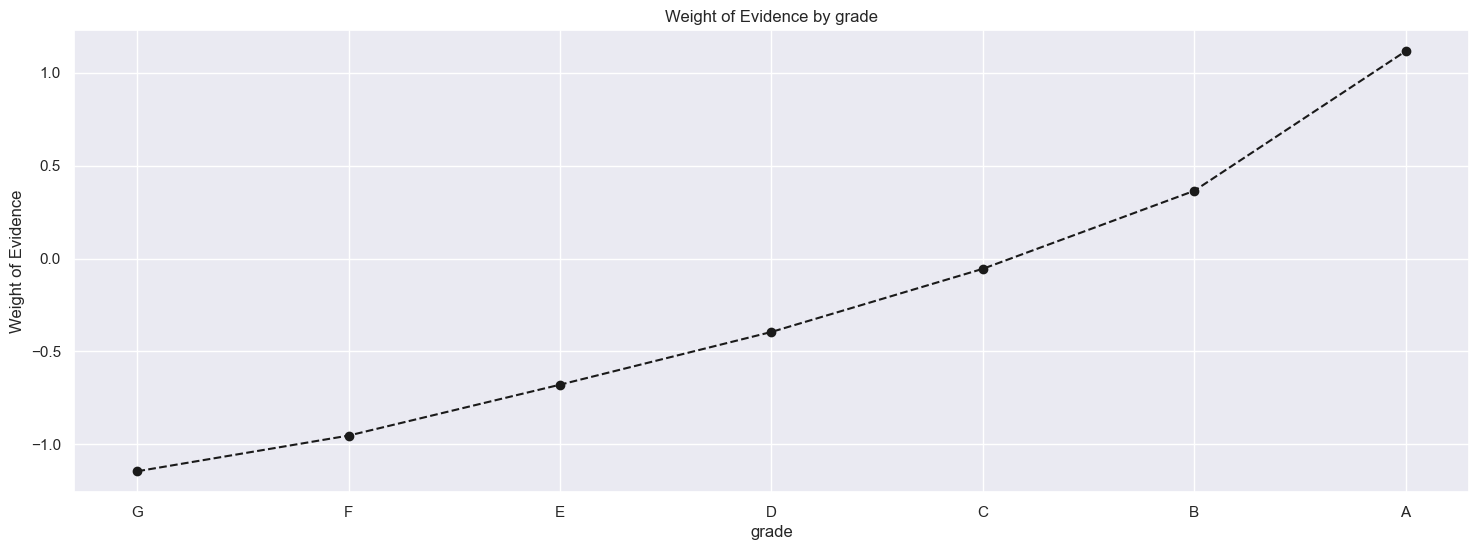

In [19]:
plot_by_woe(woe_discrete('grade'))

# Looks good, all bins aligned with credit intuition. 
# No coarse-classing / dropping of bins needed. 

In [20]:
grade_map = dict(zip(woe_discrete('grade')['grade'], woe_discrete('grade')['WoE']))
df['grade_WoE'] = df['grade'].map(grade_map)

<h4> For 'Home Ownership' - Keep but drop 'ANY' bin</h4>

In [21]:
woe_discrete('home_ownership')

,home_ownership,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
3,OTHER,182,0.208791,0.791209,38.0,144.0,0.000746,0.000347,-0.765613,-0.000399,0.021676
2,NONE,46,0.173913,0.826087,8.0,38.0,0.000157,0.000092,-0.539696,-0.000065,0.021676
5,RENT,188456,0.126104,0.873896,23765.0,164691.0,0.466300,0.396568,-0.161983,-0.069733,0.021676
4,OWN,41703,0.108266,0.891734,4515.0,37188.0,0.088590,0.089547,0.010741,0.000957,0.021676
1,MORTGAGE,235868,0.095982,0.904018,22639.0,213229.0,0.444207,0.513445,0.144852,0.069238,0.021676
0,ANY,1,0.000000,1.000000,0.0,1.0,0.000000,0.000002,inf,0.000002,0.021676


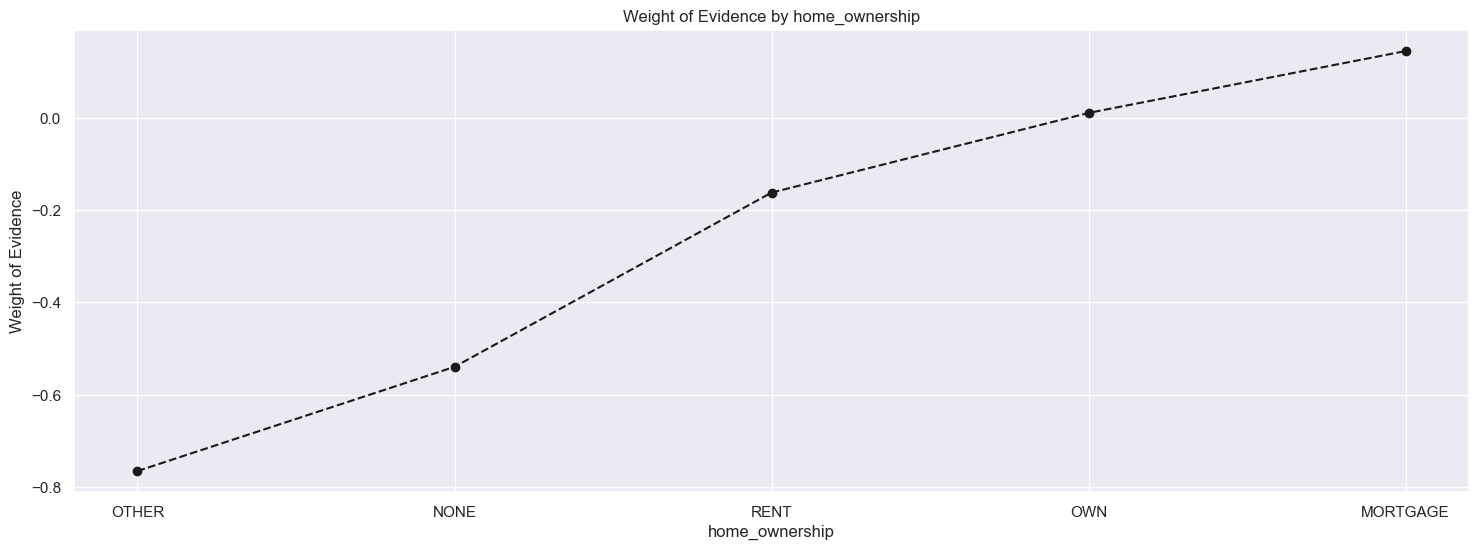

In [22]:
plot_by_woe(woe_discrete('home_ownership'))
# Looks ok.
# Own and Mortgage seems to be against credit intuition. 
# Decide to keep the sequence for now since difference not very big. 

<p> Decide to drop 'ANY' since contains 1 count, and has no Information Value due to no bad rate </p>

In [23]:
df = df[df['home_ownership'] != 'ANY']

In [24]:
woe_discrete('home_ownership')

,home_ownership,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
2,OTHER,182,0.208791,0.791209,38.0,144.0,0.000746,0.000347,-0.765611,-0.000399,0.021676
1,NONE,46,0.173913,0.826087,8.0,38.0,0.000157,0.000092,-0.539693,-0.000065,0.021676
4,RENT,188456,0.126104,0.873896,23765.0,164691.0,0.466300,0.396569,-0.161981,-0.069732,0.021676
3,OWN,41703,0.108266,0.891734,4515.0,37188.0,0.088590,0.089547,0.010743,0.000957,0.021676
0,MORTGAGE,235868,0.095982,0.904018,22639.0,213229.0,0.444207,0.513446,0.144855,0.069239,0.021676


<h4> For 'Address State' </h4>

In [25]:
woe_discrete('addr_state')       

,addr_state,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
28,NE,14,0.571429,0.428571,8.0,6.0,0.000157,0.000014,-2.385520,-0.000143,0.012536
12,IA,14,0.214286,0.785714,3.0,11.0,0.000059,0.000026,-0.798555,-0.000032,0.012536
32,NV,6519,0.137138,0.862862,894.0,5625.0,0.017541,0.013545,-0.258567,-0.003997,0.012536
11,HI,2487,0.126257,0.873743,314.0,2173.0,0.006161,0.005232,-0.163367,-0.000929,0.012536
9,FL,31635,0.125367,0.874633,3966.0,27669.0,0.077818,0.066626,-0.155283,-0.011192,0.012536
1,AL,5853,0.123526,0.876474,723.0,5130.0,0.014186,0.012353,-0.138386,-0.001833,0.012536
33,NY,40233,0.116844,0.883156,4701.0,35532.0,0.092240,0.085559,-0.075180,-0.006680,0.012536
18,LA,5488,0.116618,0.883382,640.0,4848.0,0.012558,0.011674,-0.072985,-0.000884,0.012536
31,NM,2588,0.115533,0.884467,299.0,2289.0,0.005867,0.005512,-0.062411,-0.000355,0.012536
35,OK,4117,0.115375,0.884625,475.0,3642.0,0.009320,0.008770,-0.060864,-0.000550,0.012536


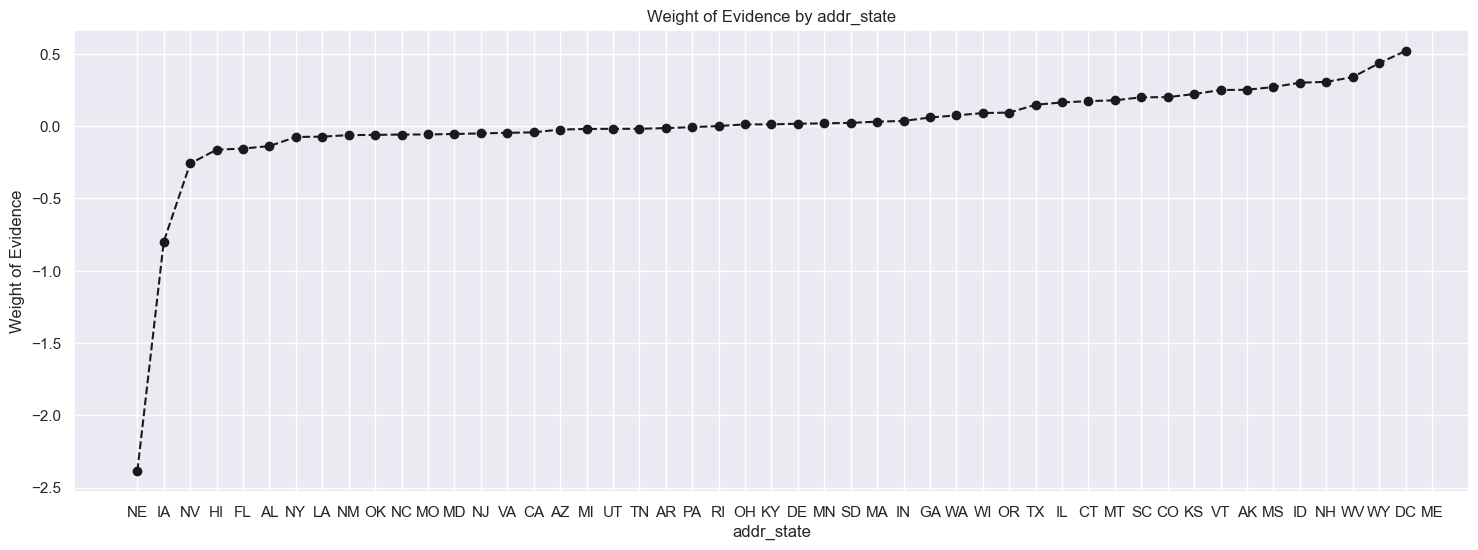

In [26]:
plot_by_woe(woe_discrete('addr_state'))

# To remove this variable, extremely low IV and not much credit intuition. 

In [27]:
df = df.drop(['addr_state'], axis = 1)

<h4> For 'Purpose' </h4>

In [28]:
woe_discrete('purpose')    

,purpose,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
11,small_business,7013,0.215742,0.784258,1513.0,5500.0,0.029687,0.013244,-0.807184,-0.016443,0.036988
3,educational,422,0.208531,0.791469,88.0,334.0,0.001727,0.000804,-0.764034,-0.000922,0.036988
10,renewable_energy,351,0.153846,0.846154,54.0,297.0,0.001060,0.000715,-0.393090,-0.000344,0.036988
8,moving,2994,0.152639,0.847361,457.0,2537.0,0.008967,0.006109,-0.383784,-0.002858,0.036988
5,house,2269,0.140150,0.859850,318.0,1951.0,0.006240,0.004698,-0.283792,-0.001542,0.036988
9,other,23662,0.138027,0.861973,3266.0,20396.0,0.064083,0.049113,-0.266065,-0.014971,0.036988
7,medical,4602,0.133855,0.866145,616.0,3986.0,0.012087,0.009598,-0.230541,-0.002489,0.036988
13,wedding,2343,0.121639,0.878361,285.0,2058.0,0.005592,0.004956,-0.120837,-0.000636,0.036988
12,vacation,2487,0.117813,0.882187,293.0,2194.0,0.005749,0.005283,-0.084529,-0.000466,0.036988
2,debt_consolidation,274193,0.113311,0.886689,31069.0,243124.0,0.609614,0.585432,-0.040477,-0.024183,0.036988


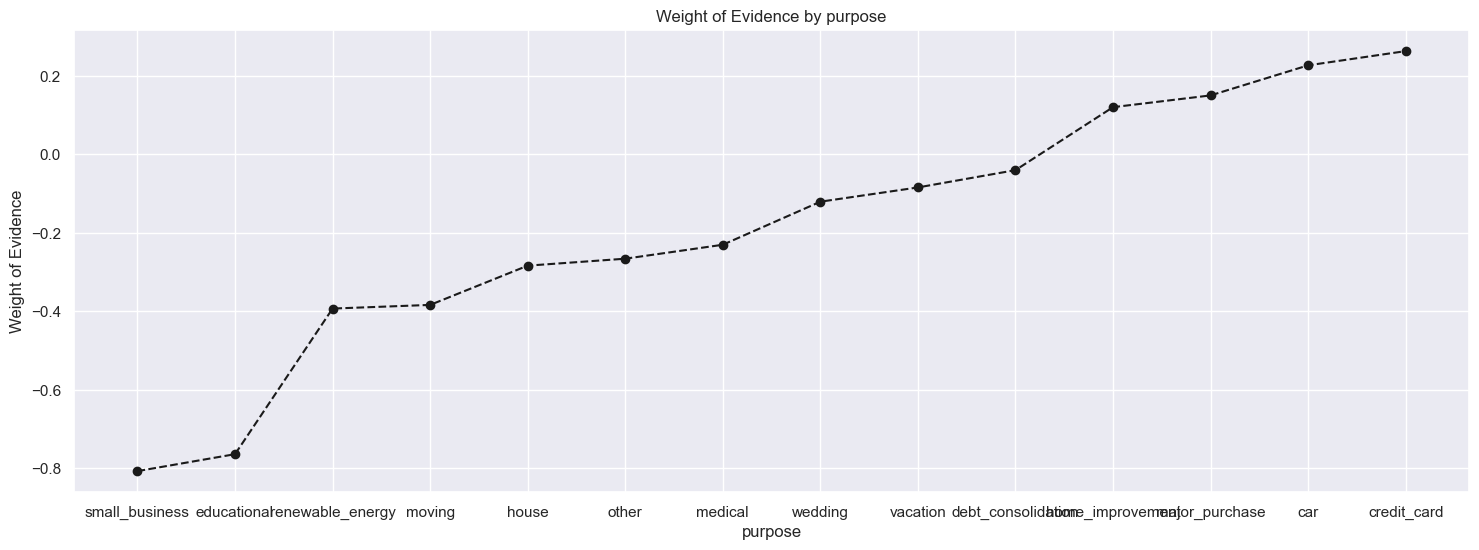

In [29]:
plot_by_woe(woe_discrete('purpose'))

# Don't really have a credit intuition behind this. Decide to keep it as it is to see how the model performs. 

In [30]:
purpose_map = dict(zip(woe_discrete('purpose')['purpose'], woe_discrete('purpose')['WoE']))
df['purpose_WoE'] = df['purpose'].map(purpose_map)

<h4> Initial List Status </h4>

In [31]:
woe_discrete('initial_list_status')    

,initial_list_status,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,f,302975,0.12031,0.87969,36451.0,266524.0,0.715216,0.641778,-0.108343,-0.073438,0.024805
1,w,163280,0.08889,0.91111,14514.0,148766.0,0.284784,0.358222,0.229423,0.073438,0.024805


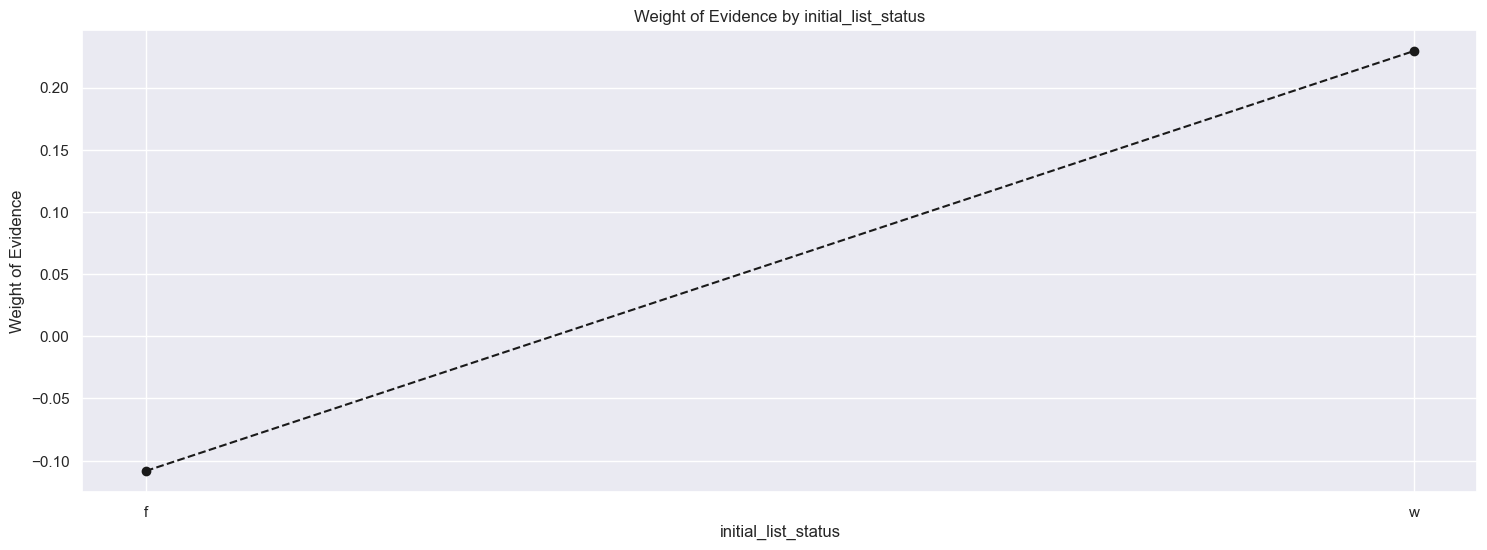

In [32]:
plot_by_woe(woe_discrete('initial_list_status'))

# Don't really have a credit intuition behind this. Decide to keep it as it is to see how the model performs. 

<p> Continuous variable </p>

In [33]:
def woe_continuous(continuous_var):
    
    WoE_results = pd.DataFrame()

    WoE_results[continuous_var] = df[continuous_var]
    WoE_results['Good_Bad'] = df['good_bad']
    
    Count = WoE_results.groupby([continuous_var]).count().reset_index()
    Mean = WoE_results.groupby([continuous_var]).mean().reset_index()

    df1 = pd.concat([Count, Mean], axis = 1)
    df1 = df1.iloc[:,[0,1,3]]

    df1.columns = [continuous_var, 'n_obs', 'prop_bad']

    df1['prop_good'] = 1 - df1['prop_bad']

    df1['n_bad'] = df1['prop_bad'] * df1['n_obs']
    df1['n_good'] = df1['prop_good'] * df1['n_obs']

    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()

    df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])

    df1['%Good - %Bad'] = df1['prop_n_good'] - df1['prop_n_bad'] 

    df1['IV'] = df1['WoE'] * df1['%Good - %Bad']
    
    df1['IV'] = np.where(df1['IV'] == np.inf, 0, df1['IV'])  # Replace infinite values with 0

    df1.IV = df1.IV.sum()

    return df1

<h4> loan_amnt </h4>

In [34]:
df['loan_amnt_factor'] = pd.qcut(df['loan_amnt'], 10)

In [35]:
woe_continuous('loan_amnt_factor')

,loan_amnt_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(499.999, 5000.0]",57025,0.106655,0.893345,6082.0,50943.0,0.119337,0.122668,0.027536,0.003332,0.003357
1,"(5000.0, 7000.0]",41027,0.098082,0.901918,4024.0,37003.0,0.078956,0.089102,0.120885,0.010145,0.003357
2,"(7000.0, 9000.0]",43715,0.109070,0.890930,4768.0,38947.0,0.093554,0.093783,0.002437,0.000228,0.003357
3,"(9000.0, 10075.0]",44814,0.108247,0.891753,4851.0,39963.0,0.095183,0.096229,0.010931,0.001046,0.003357
4,"(10075.0, 12000.0]",47428,0.105781,0.894219,5017.0,42411.0,0.098440,0.102124,0.036738,0.003684,0.003357
5,"(12000.0, 15000.0]",56131,0.105557,0.894443,5925.0,50206.0,0.116256,0.120894,0.039116,0.004638,0.003357
6,"(15000.0, 18000.0]",43176,0.118075,0.881925,5098.0,38078.0,0.100029,0.091690,-0.087050,-0.008339,0.003357
7,"(18000.0, 21000.0]",45094,0.110813,0.889187,4997.0,40097.0,0.098048,0.096552,-0.015374,-0.001496,0.003357
8,"(21000.0, 26000.0]",41391,0.114300,0.885700,4731.0,36660.0,0.092828,0.088276,-0.050288,-0.004553,0.003357
9,"(26000.0, 35000.0]",46454,0.117794,0.882206,5472.0,40982.0,0.107368,0.098683,-0.084349,-0.008685,0.003357


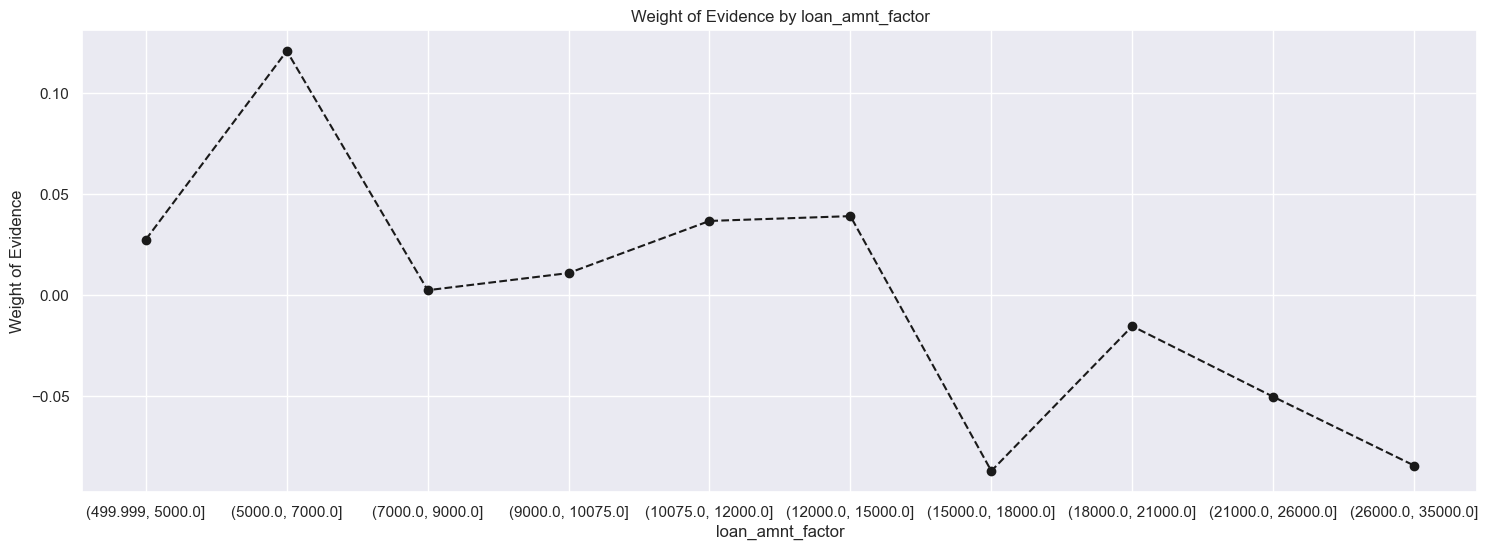

In [36]:
plot_by_woe(woe_continuous('loan_amnt_factor'))

<h4> funded_amnt </h4>

In [37]:
df['funded_amnt_factor'] = pd.qcut(df['funded_amnt'], 10)

In [38]:
woe_continuous('funded_amnt_factor')

,funded_amnt_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(499.999, 5000.0]",57133,0.106873,0.893127,6106.0,51027.0,0.119808,0.122871,0.025245,0.003063,0.003141
1,"(5000.0, 7000.0]",41180,0.098349,0.901651,4050.0,37130.0,0.079466,0.089407,0.117870,0.009941,0.003141
2,"(7000.0, 9000.0]",43769,0.108913,0.891087,4767.0,39002.0,0.093535,0.093915,0.004058,0.000380,0.003141
3,"(9000.0, 10050.0]",44586,0.108173,0.891827,4823.0,39763.0,0.094634,0.095748,0.011703,0.001114,0.003141
4,"(10050.0, 12000.0]",47769,0.106366,0.893634,5081.0,42688.0,0.099696,0.102791,0.030572,0.003095,0.003141
5,"(12000.0, 15000.0]",56233,0.105543,0.894457,5935.0,50298.0,0.116452,0.121115,0.039260,0.004663,0.003141
6,"(15000.0, 18000.0]",43290,0.118295,0.881705,5121.0,38169.0,0.100481,0.091909,-0.089164,-0.008571,0.003141
7,"(18000.0, 21000.0]",44975,0.111017,0.888983,4993.0,39982.0,0.097969,0.096275,-0.017446,-0.001694,0.003141
8,"(21000.0, 26000.0]",41090,0.113677,0.886323,4671.0,36419.0,0.091651,0.087695,-0.044121,-0.003956,0.003141
9,"(26000.0, 35000.0]",46230,0.117197,0.882803,5418.0,40812.0,0.106308,0.098273,-0.078589,-0.008035,0.003141


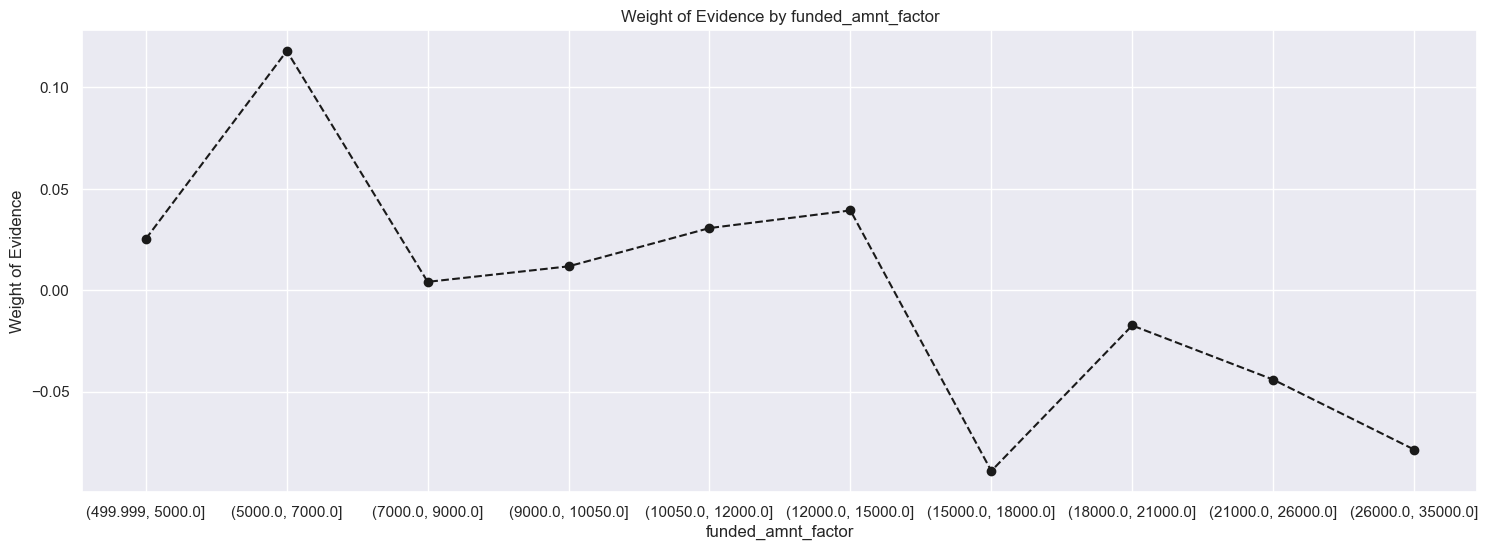

In [39]:
plot_by_woe(woe_continuous('funded_amnt_factor'))

<h4> funded_amnt_inv </h4>

In [40]:
df['funded_amnt_inv_factor'] = pd.qcut(df['funded_amnt_inv'], 10)

In [41]:
woe_continuous('funded_amnt_inv_factor')

,funded_amnt_inv_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 5000.0]",58829,0.111459,0.888541,6557.0,52272.0,0.128657,0.125869,-0.021910,-0.002788,0.003122
1,"(5000.0, 7000.0]",41181,0.098322,0.901678,4049.0,37132.0,0.079447,0.089412,0.118171,0.009966,0.003122
2,"(7000.0, 9000.0]",43643,0.108196,0.891804,4722.0,38921.0,0.092652,0.093720,0.011464,0.001068,0.003122
3,"(9000.0, 10000.0]",43899,0.107018,0.892982,4698.0,39201.0,0.092181,0.094394,0.023727,0.002213,0.003122
4,"(10000.0, 12000.0]",47972,0.106104,0.893896,5090.0,42882.0,0.099872,0.103258,0.033336,0.003386,0.003122
5,"(12000.0, 15000.0]",55999,0.105109,0.894891,5886.0,50113.0,0.115491,0.120670,0.043866,0.005179,0.003122
6,"(15000.0, 18000.0]",43106,0.117756,0.882244,5076.0,38030.0,0.099598,0.091575,-0.083986,-0.008023,0.003122
7,"(18000.0, 20800.0]",38377,0.114496,0.885504,4394.0,33983.0,0.086216,0.081830,-0.052218,-0.004386,0.003122
8,"(20800.0, 26000.0]",47093,0.108360,0.891640,5103.0,41990.0,0.100128,0.101110,0.009765,0.000983,0.003122
9,"(26000.0, 35000.0]",46156,0.116778,0.883222,5390.0,40766.0,0.105759,0.098163,-0.074535,-0.007596,0.003122


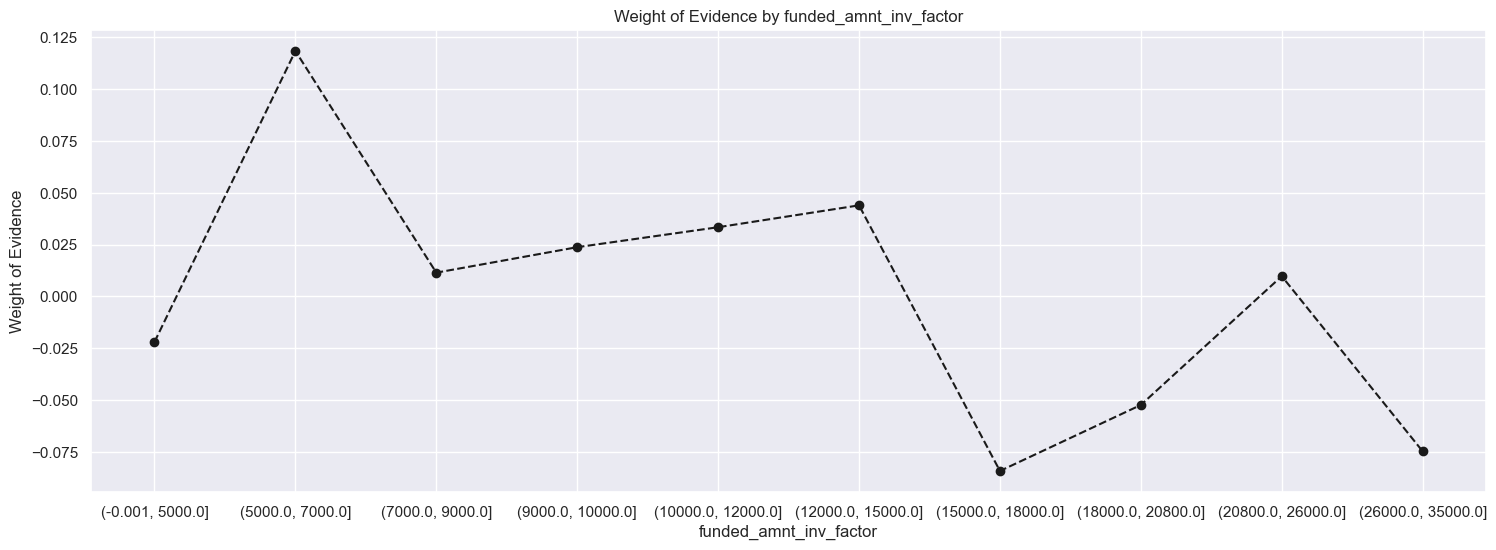

In [42]:
plot_by_woe(woe_continuous('funded_amnt_inv_factor'))

<h4> int_rate </h4>

In [43]:
df['int_rate_factor'] = pd.qcut(df['int_rate'], 10)

In [44]:
woe_continuous('int_rate_factor')

,int_rate_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(5.419, 7.9]",53465,0.034265,0.965735,1832.0,51633.0,0.035946,0.124330,1.240915,0.088384,0.322279
1,"(7.9, 9.91]",39933,0.049733,0.950267,1986.0,37947.0,0.038968,0.091375,0.852230,0.052407,0.322279
2,"(9.91, 11.49]",46781,0.071589,0.928411,3349.0,43432.0,0.065712,0.104582,0.464697,0.038871,0.322279
3,"(11.49, 12.49]",47071,0.078923,0.921077,3715.0,43356.0,0.072893,0.104399,0.359228,0.031506,0.322279
4,"(12.49, 13.66]",47227,0.095920,0.904080,4530.0,42697.0,0.088885,0.102812,0.145569,0.013928,0.322279
5,"(13.66, 14.49]",45669,0.110381,0.889619,5041.0,40628.0,0.098911,0.097830,-0.010985,-0.001081,0.322279
6,"(14.49, 15.8]",49407,0.123221,0.876779,6088.0,43319.0,0.119455,0.104310,-0.135566,-0.015144,0.322279
7,"(15.8, 17.57]",50361,0.145986,0.854014,7352.0,43009.0,0.144256,0.103564,-0.331401,-0.040692,0.322279
8,"(17.57, 19.52]",41159,0.177555,0.822445,7308.0,33851.0,0.143393,0.081512,-0.564839,-0.061881,0.322279
9,"(19.52, 26.06]",45182,0.216104,0.783896,9764.0,35418.0,0.191582,0.085285,-0.809320,-0.106297,0.322279


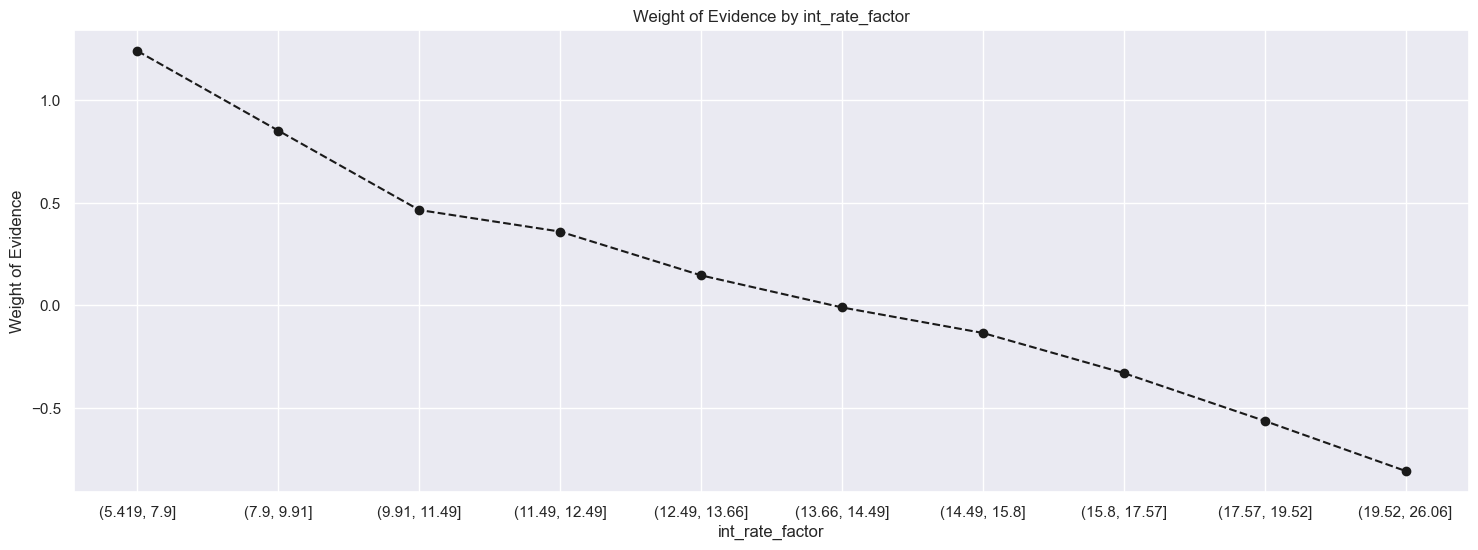

In [45]:
plot_by_woe(woe_continuous('int_rate_factor'))

In [46]:
int_rate_factor_map = dict(zip(woe_continuous('int_rate_factor')['int_rate_factor'], woe_continuous('int_rate_factor')['WoE']))
df['int_rate_factor_WoE'] = df['int_rate_factor'].map(int_rate_factor_map)

<h4> installment </h4>

In [47]:
df['installment_factor'] = pd.qcut(df['installment'], 10)

In [48]:
woe_continuous('installment_factor')

,installment_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(15.669, 163.08]",46634,0.103358,0.896642,4820.0,41814.0,0.094575,0.100686,0.062619,0.006112,0.004543
1,"(163.08, 226.37]",46700,0.102013,0.897987,4764.0,41936.0,0.093476,0.100980,0.077219,0.007504,0.004543
2,"(226.37, 281.62]",46549,0.099744,0.900256,4643.0,41906.0,0.091102,0.100908,0.102230,0.009806,0.004543
3,"(281.62, 331.942]",46619,0.105665,0.894335,4926.0,41693.0,0.096655,0.100395,0.037968,0.003740,0.004543
4,"(331.942, 379.92]",46630,0.114283,0.885717,5329.0,41301.0,0.104562,0.099451,-0.050115,-0.005111,0.004543
5,"(379.92, 449.69]",46622,0.113080,0.886920,5272.0,41350.0,0.103444,0.099569,-0.038175,-0.003875,0.004543
6,"(449.69, 518.62]",46626,0.109274,0.890726,5095.0,41531.0,0.099971,0.100005,0.000343,0.000034,0.004543
7,"(518.62, 622.78]",46627,0.121689,0.878311,5674.0,40953.0,0.111331,0.098613,-0.121307,-0.012718,0.004543
8,"(622.78, 773.68]",46626,0.107901,0.892099,5031.0,41595.0,0.098715,0.100159,0.014523,0.001444,0.004543
9,"(773.68, 1409.99]",46622,0.116061,0.883939,5411.0,41211.0,0.106171,0.099234,-0.067567,-0.006937,0.004543


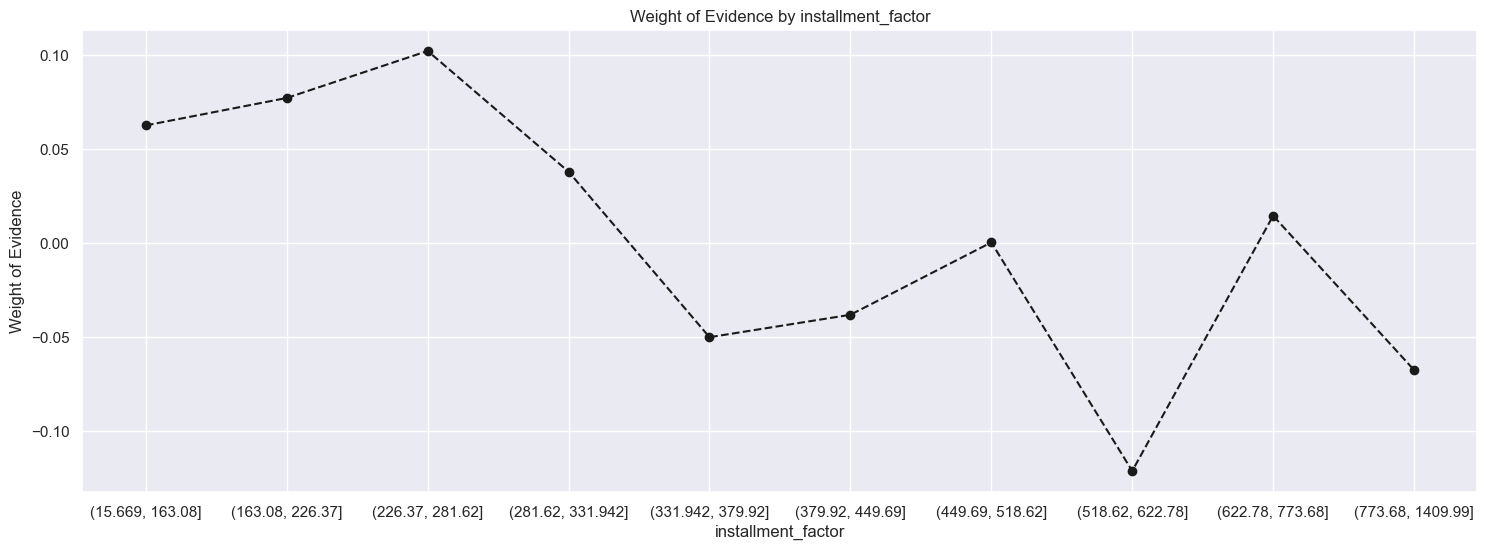

In [49]:
plot_by_woe(woe_continuous('installment_factor'))

<h4> annual_inc </h4>

In [50]:
df['annual_inc_factor'] = pd.qcut(df['annual_inc'], 10)

In [51]:
woe_continuous('annual_inc_factor')

,annual_inc_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(1895.999, 34000.0]",48550,0.145973,0.854027,7087.0,41463.0,0.139056,0.099841,-0.331299,-0.039215,0.05422
1,"(34000.0, 41600.0]",44921,0.136128,0.863872,6115.0,38806.0,0.119984,0.093443,-0.250008,-0.026541,0.05422
2,"(41600.0, 49000.0]",46940,0.126608,0.873392,5943.0,40997.0,0.116609,0.098719,-0.166553,-0.017890,0.05422
3,"(49000.0, 55000.0]",49332,0.117105,0.882895,5777.0,43555.0,0.113352,0.104879,-0.077698,-0.008474,0.05422
4,"(55000.0, 63000.0]",45834,0.116180,0.883820,5325.0,40509.0,0.104483,0.097544,-0.068726,-0.006940,0.05422
5,"(63000.0, 71000.0]",44811,0.106045,0.893955,4752.0,40059.0,0.093240,0.096460,0.033950,0.003220,0.05422
6,"(71000.0, 81000.0]",46559,0.098542,0.901458,4588.0,41971.0,0.090023,0.101064,0.115697,0.011042,0.05422
7,"(81000.0, 96000.0]",47858,0.088595,0.911405,4240.0,43618.0,0.083194,0.105030,0.233069,0.021836,0.05422
8,"(96000.0, 120000.0]",46808,0.082294,0.917706,3852.0,42956.0,0.075581,0.103436,0.313746,0.027855,0.05422
9,"(120000.0, 7500000.0]",44642,0.073608,0.926392,3286.0,41356.0,0.064476,0.099583,0.434709,0.035108,0.05422


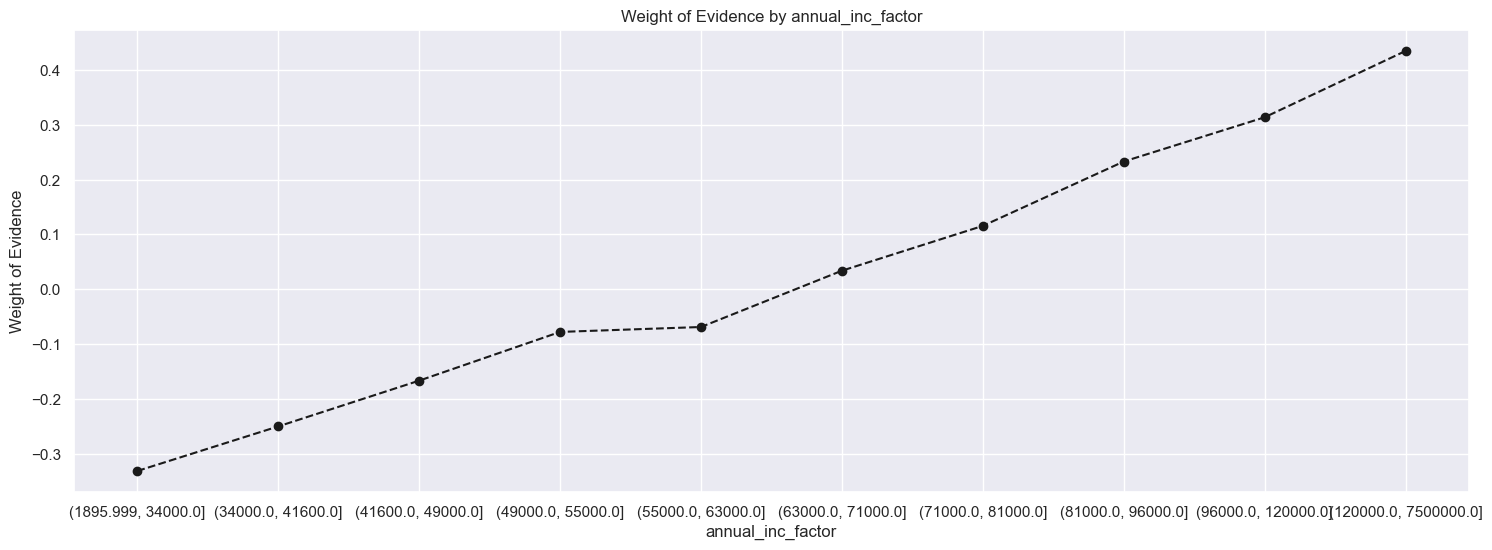

In [52]:
plot_by_woe(woe_continuous('annual_inc_factor'))

In [53]:
annual_inc_factor_map = dict(zip(woe_continuous('annual_inc_factor')['annual_inc_factor'], woe_continuous('annual_inc_factor')['WoE']))
df['annual_inc_factor_WoE'] = df['annual_inc_factor'].map(annual_inc_factor_map)

<h4> dti </h4>

In [54]:
df['dti_factor'] = pd.qcut(df['dti'], 10)

In [55]:
woe_continuous('dti_factor')

,dti_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 7.03]",46660,0.088684,0.911316,4138.0,42522.0,0.081193,0.102391,0.231971,0.021198,0.025989
1,"(7.03, 10.11]",46706,0.089475,0.910525,4179.0,42527.0,0.081997,0.102403,0.222229,0.020406,0.025989
2,"(10.11, 12.53]",46588,0.094960,0.905040,4424.0,42164.0,0.086805,0.101529,0.156685,0.014724,0.025989
3,"(12.53, 14.71]",46641,0.099033,0.900967,4619.0,42022.0,0.090631,0.101187,0.110177,0.010556,0.025989
4,"(14.71, 16.87]",46629,0.103626,0.896374,4832.0,41797.0,0.094810,0.100645,0.059726,0.005835,0.025989
5,"(16.87, 19.08]",46662,0.111590,0.888410,5207.0,41455.0,0.102168,0.099822,-0.023233,-0.002346,0.025989
6,"(19.08, 21.46]",46675,0.118265,0.881735,5520.0,41155.0,0.108310,0.099099,-0.088870,-0.009210,0.025989
7,"(21.46, 24.21]",46466,0.125124,0.874876,5814.0,40652.0,0.114078,0.097888,-0.153059,-0.016190,0.025989
8,"(24.21, 28.0]",46649,0.129756,0.870244,6053.0,40596.0,0.118768,0.097753,-0.194722,-0.021014,0.025989
9,"(28.0, 39.99]",46579,0.132656,0.867344,6179.0,40400.0,0.121240,0.097281,-0.220165,-0.023959,0.025989


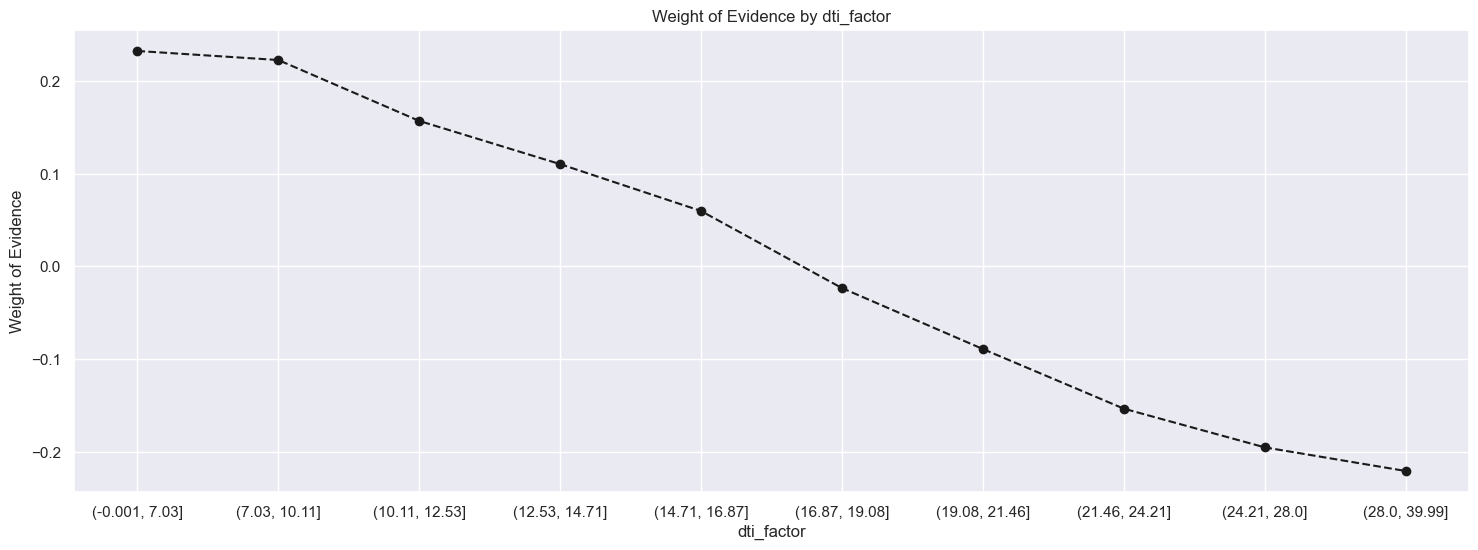

In [56]:
plot_by_woe(woe_continuous('dti_factor'))

In [57]:
dti_factor_map = dict(zip(woe_continuous('dti_factor')['dti_factor'], woe_continuous('dti_factor')['WoE']))
df['dti_factor_WoE'] = df['dti_factor'].map(dti_factor_map)

<h4> delinq_2yrs </h4>

In [58]:
df['delinq_2yrs_factor'] = np.where(df['delinq_2yrs'] == 0,  0, 1)

In [59]:
woe_continuous('delinq_2yrs_factor')

,delinq_2yrs_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0,382953,0.109413,0.890587,41900.0,341053.0,0.822133,0.821241,-0.001086,-0.000892,0.000005
1,1,83302,0.108821,0.891179,9065.0,74237.0,0.177867,0.178759,0.005004,0.000892,0.000005


<h4> inq_last_6mths </h4>

In [60]:
df['inq_last_6mths_factor'] = np.where(df['inq_last_6mths'].isin([0,1,2,3,4,5,6,7,8,9]), df['inq_last_6mths'], 10)

In [61]:
woe_continuous('inq_last_6mths_factor')

,inq_last_6mths_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,241497,0.091264,0.908736,22040.0,219457.0,0.432454,0.528443,0.200459,0.095989,0.051619
1,1.0,130148,0.115561,0.884439,15040.0,115108.0,0.295104,0.277175,-0.062680,-0.017929,0.051619
2,2.0,57825,0.136394,0.863606,7887.0,49938.0,0.154753,0.120249,-0.252272,-0.034505,0.051619
3,3.0,25126,0.158999,0.841001,3995.0,21131.0,0.078387,0.050883,-0.432140,-0.027505,0.051619
4,4.0,7241,0.153018,0.846982,1108.0,6133.0,0.021740,0.014768,-0.386711,-0.006972,0.051619
5,5.0,2768,0.171604,0.828396,475.0,2293.0,0.009320,0.005521,-0.523536,-0.003799,0.051619
6,6.0,1188,0.216330,0.783670,257.0,931.0,0.005043,0.002242,-0.810655,-0.002801,0.051619
7,7.0,195,0.348718,0.651282,68.0,127.0,0.001334,0.000306,-1.473159,-0.001028,0.051619
8,8.0,122,0.377049,0.622951,46.0,76.0,0.000903,0.000183,-1.595746,-0.000720,0.051619
9,9.0,50,0.360000,0.640000,18.0,32.0,0.000353,0.000077,-1.522474,-0.000276,0.051619


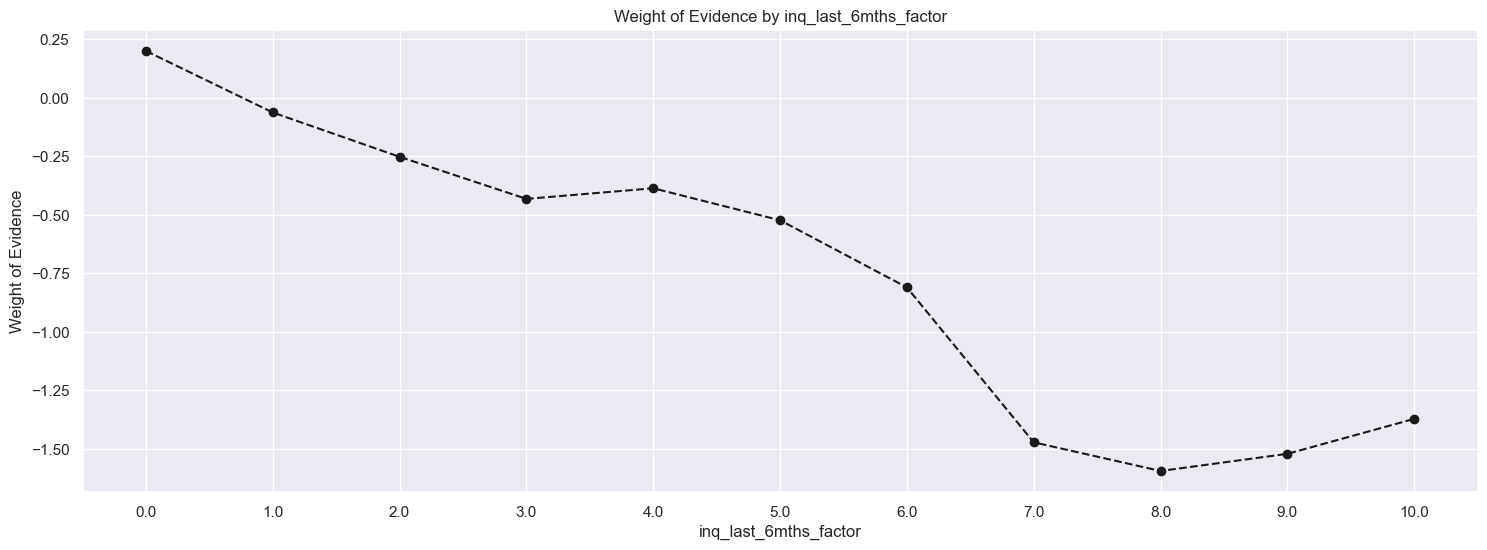

In [62]:
plot_by_woe(woe_continuous('inq_last_6mths_factor'))

In [63]:
inq_last_6mths_factor_map = dict(zip(woe_continuous('inq_last_6mths_factor')['inq_last_6mths_factor'], woe_continuous('inq_last_6mths_factor')['WoE']))
df['inq_last_6mths_factor_WoE'] = df['inq_last_6mths_factor'].map(inq_last_6mths_factor_map)

<h4> mths_since_last_delinq </h4>

In [64]:
df['mths_since_last_delinq_factor'] = pd.qcut(df['mths_since_last_delinq'], 10)

In [65]:
woe_continuous('mths_since_last_delinq_factor')

,mths_since_last_delinq_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 8.0]",24731,0.116979,0.883021,2893.0,21838.0,0.124248,0.113356,-0.091746,-0.010892,0.001713
1,"(8.0, 13.0]",20871,0.107613,0.892387,2246.0,18625.0,0.096461,0.096678,0.002250,0.000217,0.001713
2,"(13.0, 18.0]",19739,0.109225,0.890775,2156.0,17583.0,0.092596,0.091270,-0.014426,-0.001326,0.001713
3,"(18.0, 24.0]",21350,0.105527,0.894473,2253.0,19097.0,0.096762,0.099128,0.024165,0.002367,0.001713
4,"(24.0, 31.0]",23231,0.104645,0.895355,2431.0,20800.0,0.104406,0.107968,0.033547,0.003562,0.001713
5,"(31.0, 38.0]",21430,0.102380,0.897620,2194.0,19236.0,0.094228,0.099850,0.057954,0.005622,0.001713
6,"(38.0, 45.0]",20176,0.107008,0.892992,2159.0,18017.0,0.092725,0.093522,0.008567,0.000798,0.001713
7,"(45.0, 55.0]",21909,0.106714,0.893286,2338.0,19571.0,0.100412,0.101589,0.011650,0.001177,0.001713
8,"(55.0, 67.8]",20902,0.105779,0.894221,2211.0,18691.0,0.094958,0.097021,0.021494,0.002063,0.001713
9,"(67.8, 188.0]",21594,0.111281,0.888719,2403.0,19191.0,0.103204,0.099616,-0.035380,-0.003588,0.001713


<h4> mths_since_last_record </h4>

In [66]:
df['mths_since_last_record_factor'] = pd.qcut(df['mths_since_last_record'], 10)

In [67]:
woe_continuous('mths_since_last_record_factor')

,mths_since_last_record_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 33.0]",6429,0.121014,0.878986,778.0,5651.0,0.116922,0.100940,-0.146986,-0.015983,0.041204
1,"(33.0, 47.0]",6134,0.076948,0.923052,472.0,5662.0,0.070935,0.101136,0.354706,0.030201,0.041204
2,"(47.0, 57.0]",6443,0.081794,0.918206,527.0,5916.0,0.079200,0.105673,0.288368,0.026473,0.041204
3,"(57.0, 66.0]",6251,0.086546,0.913454,541.0,5710.0,0.081304,0.101993,0.226707,0.020689,0.041204
4,"(66.0, 76.0]",6224,0.092545,0.907455,576.0,5648.0,0.086564,0.100886,0.153101,0.014321,0.041204
5,"(76.0, 88.0]",6604,0.115536,0.884464,763.0,5841.0,0.114668,0.104333,-0.094448,-0.010334,0.041204
6,"(88.0, 98.0]",6420,0.135358,0.864642,869.0,5551.0,0.130598,0.099153,-0.275458,-0.031445,0.041204
7,"(98.0, 105.0]",5971,0.120918,0.879082,722.0,5249.0,0.108506,0.093759,-0.146080,-0.014747,0.041204
8,"(105.0, 112.0]",6702,0.116234,0.883766,779.0,5923.0,0.117072,0.105798,-0.101260,-0.011274,0.041204
9,"(112.0, 129.0]",5460,0.114835,0.885165,627.0,4833.0,0.094229,0.086328,-0.087572,-0.007901,0.041204


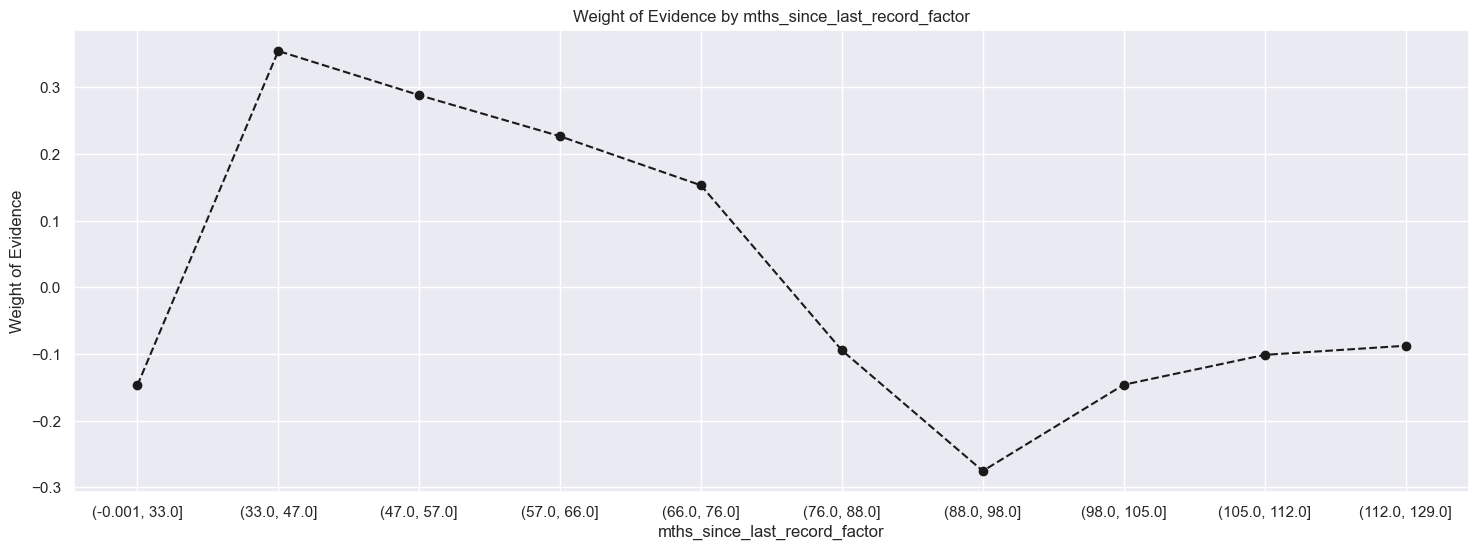

In [68]:
plot_by_woe(woe_continuous('mths_since_last_record_factor'))   #too many missing, cannot use

<h4> open_acc </h4>

In [69]:
df['open_acc_factor'] = pd.qcut(df['open_acc'], 10)

In [70]:
woe_continuous('open_acc_factor')

,open_acc_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 6.0]",72408,0.111231,0.888769,8054.0,64354.0,0.158030,0.154962,-0.019608,-0.003068,0.000597
1,"(6.0, 7.0]",37601,0.109385,0.890615,4113.0,33488.0,0.080702,0.080638,-0.000803,-0.000065,0.000597
2,"(7.0, 8.0]",41893,0.108491,0.891509,4545.0,37348.0,0.089179,0.089932,0.008414,0.000753,0.000597
3,"(8.0, 9.0]",44019,0.110998,0.889002,4886.0,39133.0,0.095870,0.094231,-0.017246,-0.001639,0.000597
4,"(9.0, 10.0]",42512,0.110933,0.889067,4716.0,37796.0,0.092534,0.091011,-0.016596,-0.001523,0.000597
5,"(10.0, 12.0]",73697,0.111836,0.888164,8242.0,65455.0,0.161719,0.157613,-0.025718,-0.004106,0.000597
6,"(12.0, 13.0]",29806,0.104979,0.895021,3129.0,26677.0,0.061395,0.064237,0.045250,0.002842,0.000597
7,"(13.0, 15.0]",44964,0.108820,0.891180,4893.0,40071.0,0.096007,0.096489,0.005009,0.000482,0.000597
8,"(15.0, 18.0]",41066,0.106000,0.894000,4353.0,36713.0,0.085412,0.088403,0.034428,0.002992,0.000597
9,"(18.0, 84.0]",38289,0.105357,0.894643,4034.0,34255.0,0.079152,0.082485,0.041236,0.003332,0.000597


<h4> pub_rec </h4>

In [71]:
df['pub_rec_factor'] = np.where(df['pub_rec'] >= 2, 2, df['pub_rec'])

In [72]:
woe_continuous('pub_rec_factor')

,pub_rec_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,404892,0.110212,0.889788,44624.0,360268.0,0.875581,0.867509,-0.009262,-0.008072,0.000868
1,1.0,53051,0.105031,0.894969,5572.0,47479.0,0.109330,0.114327,0.044696,0.004997,0.000868
2,2.0,8312,0.092517,0.907483,769.0,7543.0,0.015089,0.018163,0.185446,0.003074,0.000868


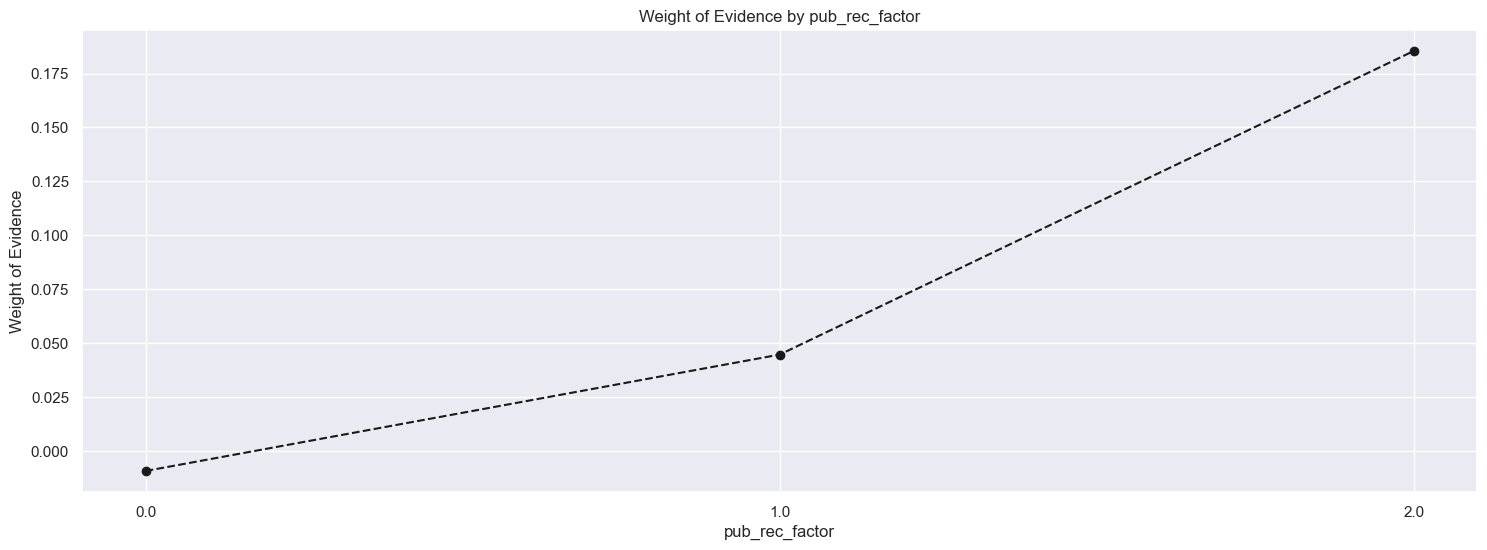

In [73]:
plot_by_woe(woe_continuous('pub_rec_factor'))

<h4> revol_bal </h4>

In [74]:
df['revol_bal_factor'] = pd.qcut(df['revol_bal'], 10)

In [75]:
woe_continuous('revol_bal_factor')

,revol_bal_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 3393.0]",46636,0.115983,0.884017,5409.0,41227.0,0.106132,0.099273,-0.066809,-0.006859,0.005762
1,"(3393.0, 5443.0]",46634,0.109898,0.890102,5125.0,41509.0,0.100559,0.099952,-0.006058,-0.000607,0.005762
2,"(5443.0, 7389.0]",46626,0.114378,0.885622,5333.0,41293.0,0.104640,0.099432,-0.051059,-0.005209,0.005762
3,"(7389.0, 9452.0]",46612,0.113340,0.886660,5283.0,41329.0,0.103659,0.099518,-0.040768,-0.004141,0.005762
4,"(9452.0, 11765.0]",46631,0.114109,0.885891,5321.0,41310.0,0.104405,0.099473,-0.048395,-0.004932,0.005762
5,"(11765.0, 14528.0]",46625,0.111871,0.888129,5216.0,41409.0,0.102345,0.099711,-0.026071,-0.002634,0.005762
6,"(14528.0, 18055.0]",46629,0.112098,0.887902,5227.0,41402.0,0.102561,0.099694,-0.028346,-0.002866,0.005762
7,"(18055.0, 23168.0]",46614,0.108787,0.891213,5071.0,41543.0,0.099500,0.100034,0.005353,0.000534,0.005762
8,"(23168.0, 31935.0]",46625,0.101598,0.898402,4737.0,41888.0,0.092946,0.100864,0.081757,0.007918,0.005762
9,"(31935.0, 2568995.0]",46623,0.091007,0.908993,4243.0,42380.0,0.083253,0.102049,0.203568,0.018796,0.005762


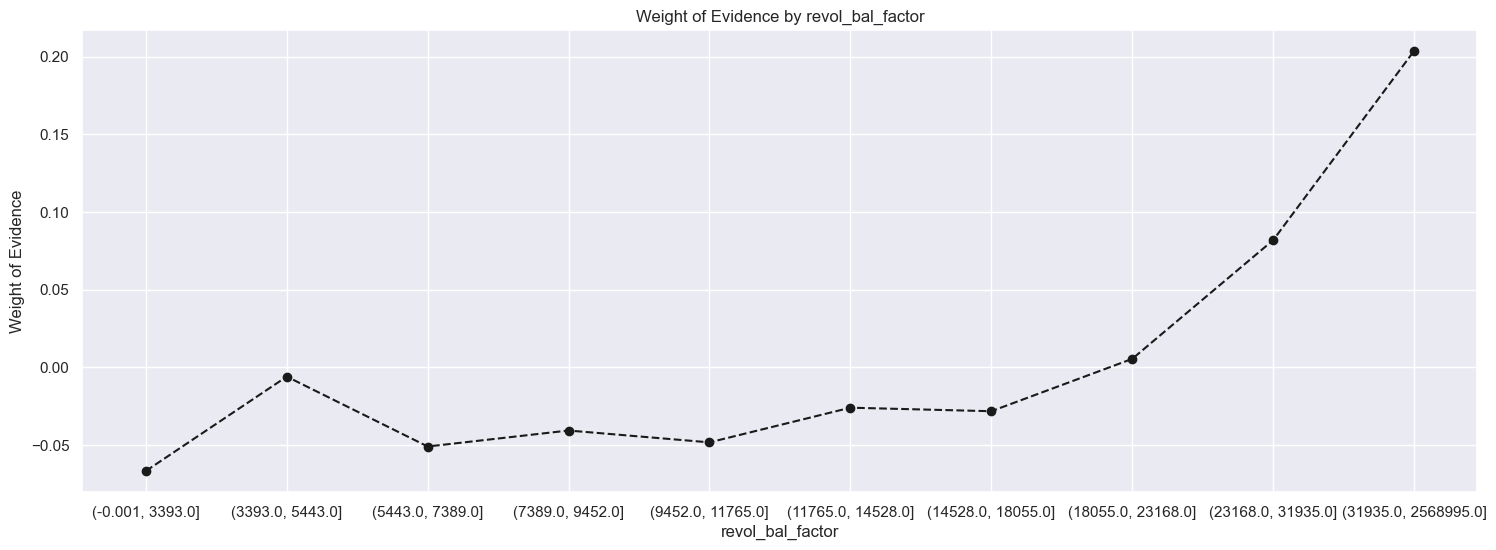

In [76]:
plot_by_woe(woe_continuous('revol_bal_factor'))

<h4> revol_util </h4>

In [77]:
df['revol_util_factor'] = pd.qcut(df['revol_util'], 10)

In [78]:
woe_continuous('revol_util_factor')

,revol_util_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 23.2]",46680,0.082905,0.917095,3870.0,42810.0,0.076016,0.103148,0.305216,0.027132,0.02685
1,"(23.2, 34.8]",46976,0.091579,0.908421,4302.0,42674.0,0.084502,0.102820,0.196209,0.018318,0.02685
2,"(34.8, 43.4]",46572,0.096496,0.903504,4494.0,42078.0,0.088273,0.101384,0.138481,0.013111,0.02685
3,"(43.4, 50.8]",46682,0.102309,0.897691,4776.0,41906.0,0.093813,0.100970,0.073525,0.007157,0.02685
4,"(50.8, 57.6]",46601,0.105663,0.894337,4924.0,41677.0,0.096720,0.100418,0.037527,0.003699,0.02685
5,"(57.6, 64.3]",46593,0.112227,0.887773,5229.0,41364.0,0.102711,0.099664,-0.030110,-0.003047,0.02685
6,"(64.3, 71.1]",46445,0.117386,0.882614,5452.0,40993.0,0.107091,0.098770,-0.080882,-0.008321,0.02685
7,"(71.1, 78.5]",46395,0.120940,0.879060,5611.0,40784.0,0.110214,0.098267,-0.114740,-0.011947,0.02685
8,"(78.5, 87.1]",46466,0.125963,0.874037,5853.0,40613.0,0.114968,0.097855,-0.161167,-0.017113,0.02685
9,"(87.1, 892.3]",46534,0.137512,0.862488,6399.0,40135.0,0.125692,0.096703,-0.262194,-0.028989,0.02685


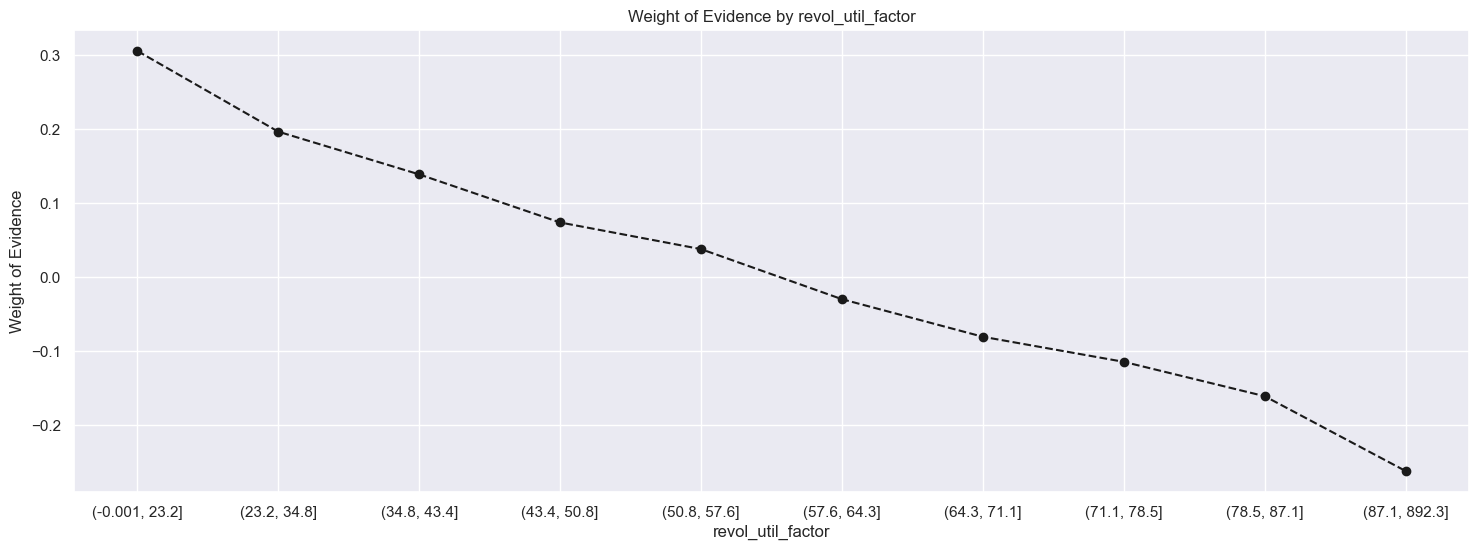

In [79]:
plot_by_woe(woe_continuous('revol_util_factor'))

<h4> total_acc </h4>

In [80]:
df['total_acc_factor'] = pd.qcut(df['total_acc'], 10)

In [81]:
woe_continuous('total_acc_factor')

,total_acc_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(0.999, 12.0]",58276,0.125403,0.874597,7308.0,50968.0,0.143393,0.122729,-0.155610,-0.020664,0.006566
1,"(12.0, 15.0]",41940,0.117334,0.882666,4921.0,37019.0,0.096556,0.089140,-0.079918,-0.007416,0.006566
2,"(15.0, 18.0]",48554,0.112143,0.887857,5445.0,43109.0,0.106838,0.103805,-0.028804,-0.003033,0.006566
3,"(18.0, 21.0]",50869,0.112288,0.887712,5712.0,45157.0,0.112077,0.108736,-0.030262,-0.003341,0.006566
4,"(21.0, 23.0]",33747,0.107861,0.892139,3640.0,30107.0,0.071422,0.072496,0.014936,0.001075,0.006566
5,"(23.0, 26.0]",47342,0.106375,0.893625,5036.0,42306.0,0.098813,0.101871,0.030479,0.003058,0.006566
6,"(26.0, 30.0]",53947,0.103305,0.896695,5573.0,48374.0,0.109350,0.116482,0.063191,0.007133,0.006566
7,"(30.0, 34.0]",41876,0.102541,0.897459,4294.0,37582.0,0.084254,0.090496,0.071469,0.006242,0.006566
8,"(34.0, 41.0]",47173,0.099930,0.900070,4714.0,42459.0,0.092495,0.102239,0.100164,0.009745,0.006566
9,"(41.0, 156.0]",42531,0.101620,0.898380,4322.0,38209.0,0.084803,0.092006,0.081515,0.007202,0.006566


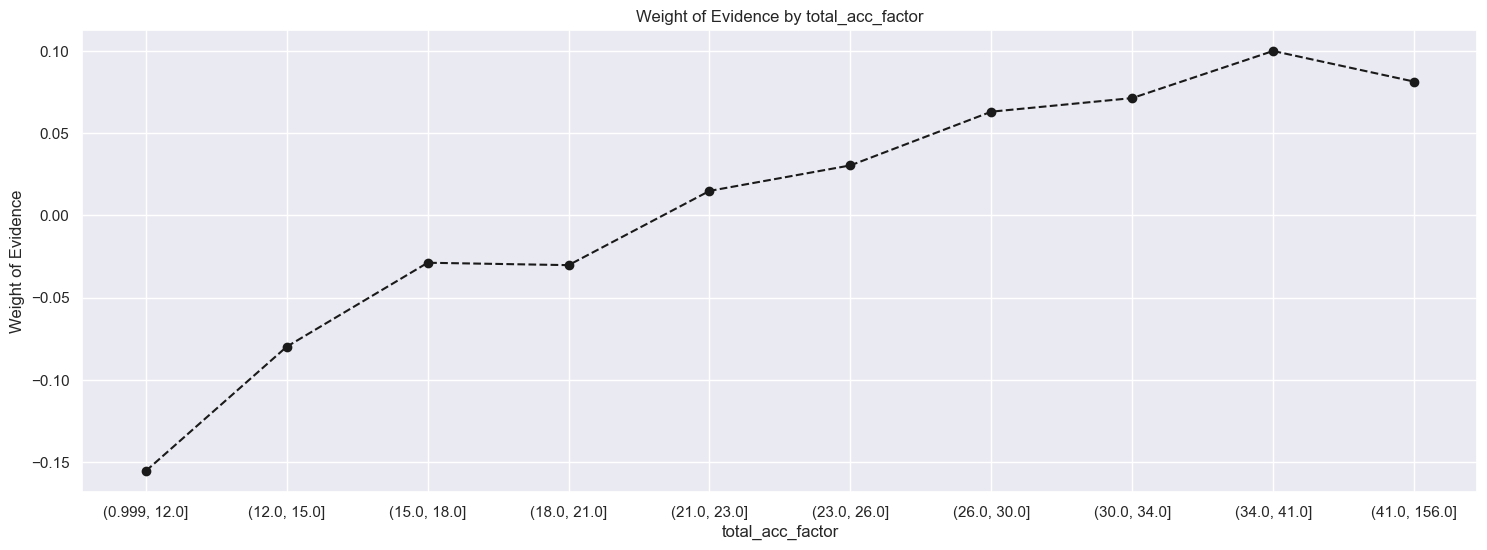

In [82]:
plot_by_woe(woe_continuous('total_acc_factor'))

<h4> mths_since_last_major_derog </h4>

In [83]:
df['mths_since_last_major_derog_factor'] = pd.qcut(df['mths_since_last_major_derog'], 10)

In [84]:
woe_continuous('mths_since_last_major_derog_factor')

,mths_since_last_major_derog_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 14.0]",10300,0.107767,0.892233,1110.0,9190.0,0.109847,0.103412,-0.060366,-0.006435,0.00253
1,"(14.0, 22.0]",10237,0.105304,0.894696,1078.0,9159.0,0.106680,0.103063,-0.034492,-0.003617,0.00253
2,"(22.0, 29.0]",9785,0.103628,0.896372,1014.0,8771.0,0.100346,0.098697,-0.016574,-0.001649,0.00253
3,"(29.0, 36.0]",10053,0.098677,0.901323,992.0,9061.0,0.098169,0.101960,0.037890,0.003791,0.00253
4,"(36.0, 42.0]",9317,0.102501,0.897499,955.0,8362.0,0.094508,0.094095,-0.004380,-0.000413,0.00253
5,"(42.0, 49.0]",11195,0.097990,0.902010,1097.0,10098.0,0.108560,0.113629,0.045636,0.005069,0.00253
6,"(49.0, 56.0]",9656,0.097970,0.902030,946.0,8710.0,0.093617,0.098011,0.045863,0.004394,0.00253
7,"(56.0, 63.0]",8778,0.092960,0.907040,816.0,7962.0,0.080752,0.089594,0.103899,0.008841,0.00253
8,"(63.0, 72.0]",10316,0.106534,0.893466,1099.0,9217.0,0.108758,0.103716,-0.047473,-0.005042,0.00253
9,"(72.0, 188.0]",9336,0.106898,0.893102,998.0,8338.0,0.098763,0.093825,-0.051296,-0.004938,0.00253


<h4> acc_now_delinq </h4>

In [85]:
woe_continuous('acc_now_delinq')

,acc_now_delinq,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,464523,0.109316,0.890684,50780.0,413743.0,0.996370,0.996275,-0.000096,-0.000095,0.000052
1,1.0,1623,0.106593,0.893407,173.0,1450.0,0.003394,0.003492,0.028189,0.000097,0.000052
2,2.0,92,0.097826,0.902174,9.0,83.0,0.000177,0.000200,0.123778,0.000023,0.000052
3,3.0,11,0.181818,0.818182,2.0,9.0,0.000039,0.000022,-0.593761,-0.000018,0.000052
4,4.0,4,0.000000,1.000000,0.0,4.0,0.000000,0.000010,inf,0.000010,0.000052
5,5.0,2,0.500000,0.500000,1.0,1.0,0.000020,0.000002,-2.097838,-0.000017,0.000052


<h4> tot_cur_bal </h4>

In [86]:
df['tot_cur_bal_factor'] = pd.qcut(df['tot_cur_bal'], 10)

In [87]:
woe_continuous('tot_cur_bal_factor')

,tot_cur_bal_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 13819.0]",39605,0.109405,0.890595,4333.0,35272.0,0.108192,0.099090,-0.087883,-0.009102,0.034727
1,"(13819.0, 23496.4]",39597,0.117231,0.882769,4642.0,34955.0,0.115908,0.098200,-0.165796,-0.017709,0.034727
2,"(23496.4, 34304.1]",39601,0.116411,0.883589,4610.0,34991.0,0.115109,0.098301,-0.157849,-0.016808,0.034727
3,"(34304.1, 50008.0]",39604,0.114155,0.885845,4521.0,35083.0,0.112887,0.098559,-0.135728,-0.014328,0.034727
4,"(50008.0, 81538.0]",39597,0.112281,0.887719,4446.0,35151.0,0.111014,0.098750,-0.117064,-0.012264,0.034727
5,"(81538.0, 132957.2]",39601,0.104922,0.895078,4155.0,35446.0,0.103748,0.099579,-0.041014,-0.004169,0.034727
6,"(132957.2, 182129.7]",39600,0.098409,0.901591,3897.0,35703.0,0.097306,0.100301,0.030316,0.002995,0.034727
7,"(182129.7, 240373.6]",39601,0.092397,0.907603,3659.0,35942.0,0.091363,0.100972,0.100005,0.009609,0.034727
8,"(240373.6, 331686.3]",39601,0.079796,0.920204,3160.0,36441.0,0.078903,0.102374,0.260411,0.023471,0.034727
9,"(331686.3, 8000078.0]",39601,0.066311,0.933689,2626.0,36975.0,0.065570,0.103874,0.460068,0.038305,0.034727


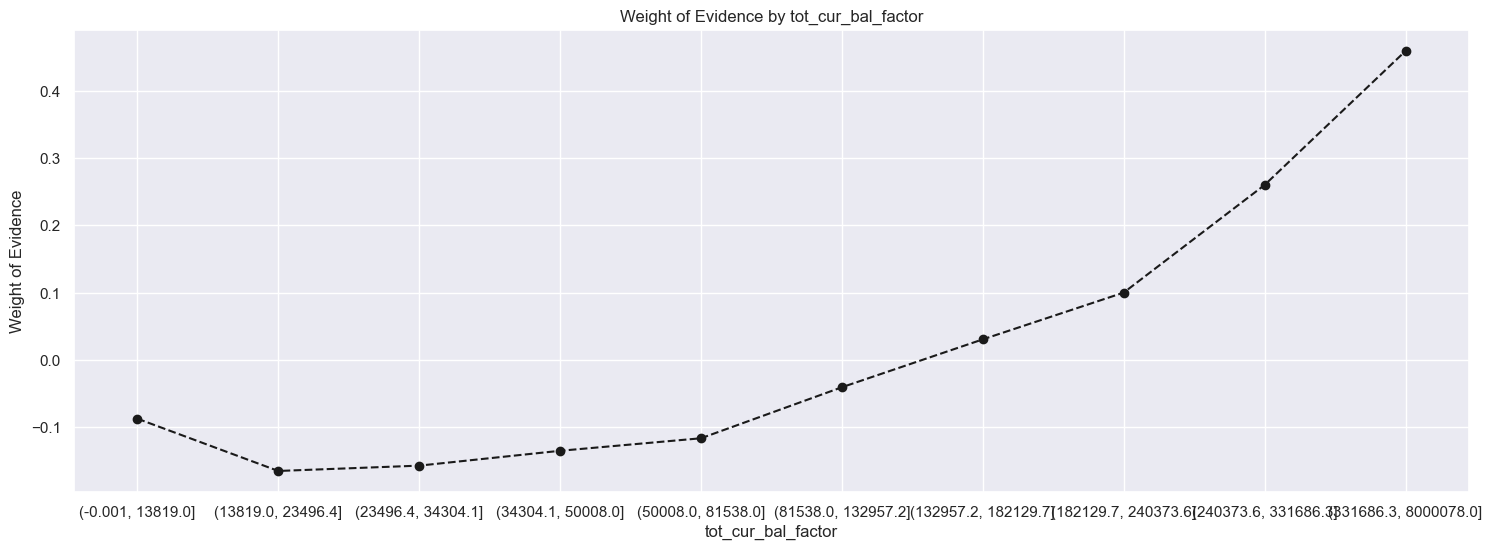

In [88]:
plot_by_woe(woe_continuous('tot_cur_bal_factor'))

<h4> total_rev_hi_lim </h4>

In [89]:
df['total_rev_hi_lim_factor'] = pd.qcut(df['total_rev_hi_lim'], 10)

In [90]:
woe_continuous('total_rev_hi_lim_factor')

,total_rev_hi_lim_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(-0.001, 6700.0]",47194,0.131436,0.868564,6203.0,40991.0,0.121711,0.098705,-0.209518,-0.023006,0.041804
1,"(6700.0, 10000.0]",49340,0.123976,0.876024,6117.0,43223.0,0.120024,0.104079,-0.142537,-0.015944,0.041804
2,"(10000.0, 13100.0]",43959,0.119202,0.880798,5240.0,38719.0,0.102816,0.093234,-0.097829,-0.009582,0.041804
3,"(13100.0, 16400.0]",46710,0.122608,0.877392,5727.0,40983.0,0.112371,0.098685,-0.129872,-0.013686,0.041804
4,"(16400.0, 20100.0]",46592,0.120385,0.879615,5609.0,40983.0,0.110056,0.098685,-0.109053,-0.011371,0.041804
5,"(20100.0, 24800.0]",46158,0.110490,0.889510,5100.0,41058.0,0.100069,0.098866,-0.012093,-0.001203,0.041804
6,"(24800.0, 30600.0]",46449,0.110487,0.889513,5132.0,41317.0,0.100697,0.099490,-0.012059,-0.001207,0.041804
7,"(30600.0, 39200.0]",46908,0.101134,0.898866,4744.0,42164.0,0.093083,0.101529,0.086848,0.008446,0.041804
8,"(39200.0, 54600.0]",46403,0.085986,0.914014,3990.0,42413.0,0.078289,0.102129,0.265826,0.023840,0.041804
9,"(54600.0, 9999999.0]",46542,0.066671,0.933329,3103.0,43439.0,0.060885,0.104599,0.541150,0.043714,0.041804


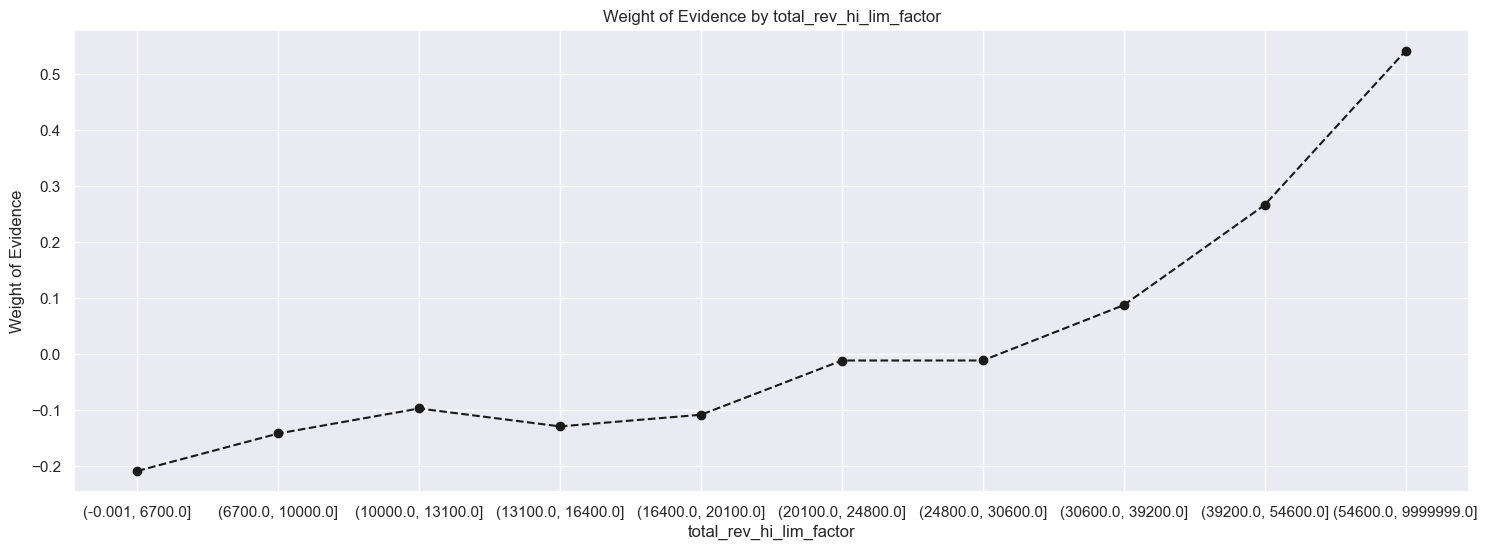

In [91]:
plot_by_woe(woe_continuous('total_rev_hi_lim_factor'))

In [92]:
total_rev_hi_lim_factor_map = dict(zip(woe_continuous('total_rev_hi_lim_factor')['total_rev_hi_lim_factor'], woe_continuous('total_rev_hi_lim_factor')['WoE']))
df['total_rev_hi_lim_factor_WoE'] = df['total_rev_hi_lim_factor'].map(total_rev_hi_lim_factor_map)

<h4> Employment Length </h4>

In [93]:
woe_continuous('emp_length_int')

,emp_length_int,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,0.0,57255,0.124007,0.875993,7100.0,50155.0,0.139311,0.120771,-0.142815,-0.018540,0.006617
1,1.0,29619,0.111854,0.888146,3313.0,26306.0,0.065005,0.063344,-0.025895,-0.001662,0.006617
2,2.0,41372,0.109760,0.890240,4541.0,36831.0,0.089100,0.088687,-0.004645,-0.000413,0.006617
3,3.0,36594,0.109499,0.890501,4007.0,32587.0,0.078623,0.078468,-0.001967,-0.000155,0.006617
4,4.0,28023,0.109589,0.890411,3071.0,24952.0,0.060257,0.060083,-0.002887,-0.000174,0.006617
5,5.0,30773,0.114971,0.885029,3538.0,27235.0,0.069420,0.065581,-0.056897,-0.003840,0.006617
6,6.0,26111,0.117115,0.882885,3058.0,23053.0,0.060002,0.055511,-0.077803,-0.004491,0.006617
7,7.0,26180,0.111345,0.888655,2915.0,23265.0,0.057196,0.056021,-0.020758,-0.001175,0.006617
8,8.0,22395,0.110069,0.889931,2465.0,19930.0,0.048367,0.047991,-0.007804,-0.000376,0.006617
9,9.0,17887,0.112093,0.887907,2005.0,15882.0,0.039341,0.038243,-0.028296,-0.001098,0.006617


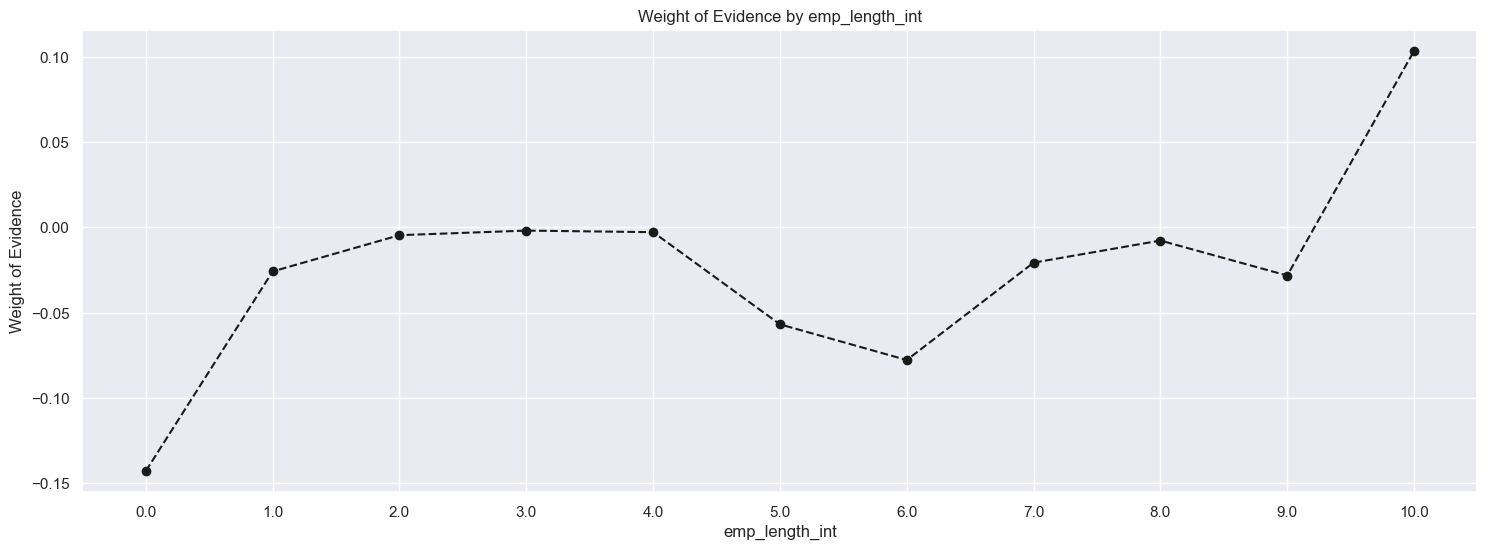

In [94]:
plot_by_woe(woe_continuous('emp_length_int'))

<h4> term_int </h4>

In [95]:
woe_continuous('term_int')

,term_int,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,36,337923,0.097084,0.902916,32807.0,305116.0,0.643716,0.734706,0.132212,0.09099,0.038862
1,60,128332,0.141492,0.858508,18158.0,110174.0,0.356284,0.265294,-0.294888,-0.09099,0.038862


In [96]:
term_int_map = dict(zip(woe_continuous('term_int')['term_int'], woe_continuous('term_int')['WoE']))
df['term_int_WoE'] = df['term_int'].map(term_int_map)

<h4> Months since earliest credit line </h4>

In [97]:
df['mths_since_earliest_cr_line_factor'] = pd.qcut(df['months_since_earliest_cr_line'], 10)

In [98]:
woe_continuous('mths_since_earliest_cr_line_factor')

,mths_since_earliest_cr_line_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(72.999, 146.0]",47395,0.131153,0.868847,6216.0,41179.0,0.121966,0.099157,-0.207036,-0.022809,0.014393
1,"(146.0, 173.0]",47623,0.118157,0.881843,5627.0,41996.0,0.110409,0.101125,-0.087840,-0.009285,0.014393
2,"(173.0, 193.0]",45703,0.115813,0.884187,5293.0,40410.0,0.103856,0.097305,-0.065146,-0.006550,0.014393
3,"(193.0, 209.0]",48290,0.112839,0.887161,5449.0,42841.0,0.106917,0.103159,-0.035774,-0.003757,0.014393
4,"(209.0, 226.0]",46125,0.114732,0.885268,5292.0,40833.0,0.103836,0.098324,-0.054544,-0.005512,0.014393
5,"(226.0, 246.0]",45189,0.110602,0.889398,4998.0,40191.0,0.098067,0.096778,-0.013233,-0.001289,0.014393
6,"(246.0, 271.0]",46695,0.105964,0.894036,4948.0,41747.0,0.097086,0.100525,0.034806,0.003439,0.014393
7,"(271.0, 304.0]",46732,0.097342,0.902658,4549.0,42183.0,0.089257,0.101575,0.129272,0.012317,0.014393
8,"(304.0, 361.0]",46376,0.095739,0.904261,4440.0,41936.0,0.087119,0.100980,0.147652,0.013861,0.014393
9,"(361.0, 887.0]",46127,0.090034,0.909966,4153.0,41974.0,0.081487,0.101072,0.215381,0.019584,0.014393


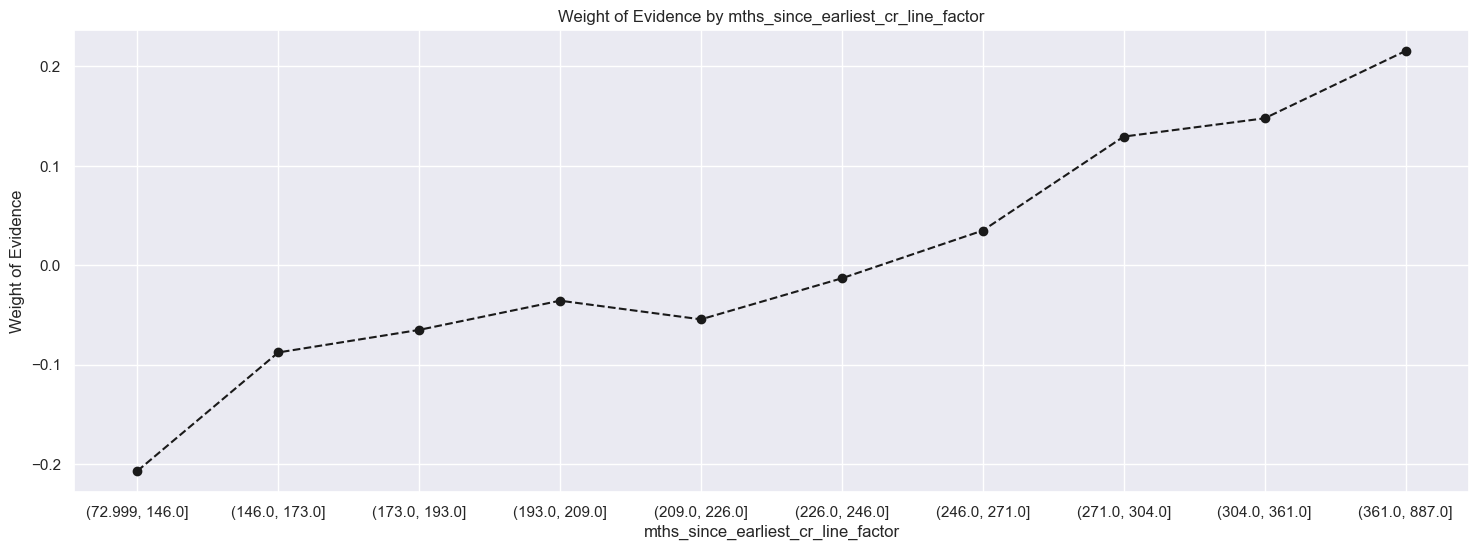

In [99]:
plot_by_woe(woe_continuous('mths_since_earliest_cr_line_factor'))

<h4> Mths_Since_Issue </h4>

In [100]:
df['mths_since_issue_d_factor'] = pd.qcut(df['mths_since_issue_d'], 10)

In [101]:
woe_continuous('mths_since_issue_d_factor')

,mths_since_issue_d_factor,n_obs,prop_bad,prop_good,n_bad,n_good,prop_n_bad,prop_n_good,WoE,%Good - %Bad,IV
0,"(35.999, 38.0]",74143,0.063607,0.936393,4716.0,69427.0,0.092534,0.167177,0.591477,0.074643,0.10794
1,"(38.0, 40.0]",29419,0.078827,0.921173,2319.0,27100.0,0.045502,0.065256,0.360560,0.019754,0.10794
2,"(40.0, 42.0]",46485,0.085791,0.914209,3988.0,42497.0,0.078250,0.102331,0.268306,0.024081,0.10794
3,"(42.0, 44.0]",38170,0.095153,0.904847,3632.0,34538.0,0.071265,0.083166,0.154439,0.011901,0.10794
4,"(44.0, 47.0]",47410,0.100949,0.899051,4786.0,42624.0,0.093908,0.102637,0.088885,0.008729,0.10794
5,"(47.0, 51.0]",56797,0.111133,0.888867,6312.0,50485.0,0.123850,0.121566,-0.018614,-0.002284,0.10794
6,"(51.0, 54.0]",35483,0.128033,0.871967,4543.0,30940.0,0.089140,0.074502,-0.179376,-0.014637,0.10794
7,"(54.0, 60.0]",48541,0.140191,0.859809,6805.0,41736.0,0.133523,0.100498,-0.284132,-0.033025,0.10794
8,"(60.0, 70.0]",44699,0.157520,0.842480,7041.0,37658.0,0.138154,0.090679,-0.421043,-0.047475,0.10794
9,"(70.0, 126.0]",45108,0.151259,0.848741,6823.0,38285.0,0.133876,0.092189,-0.373079,-0.041688,0.10794


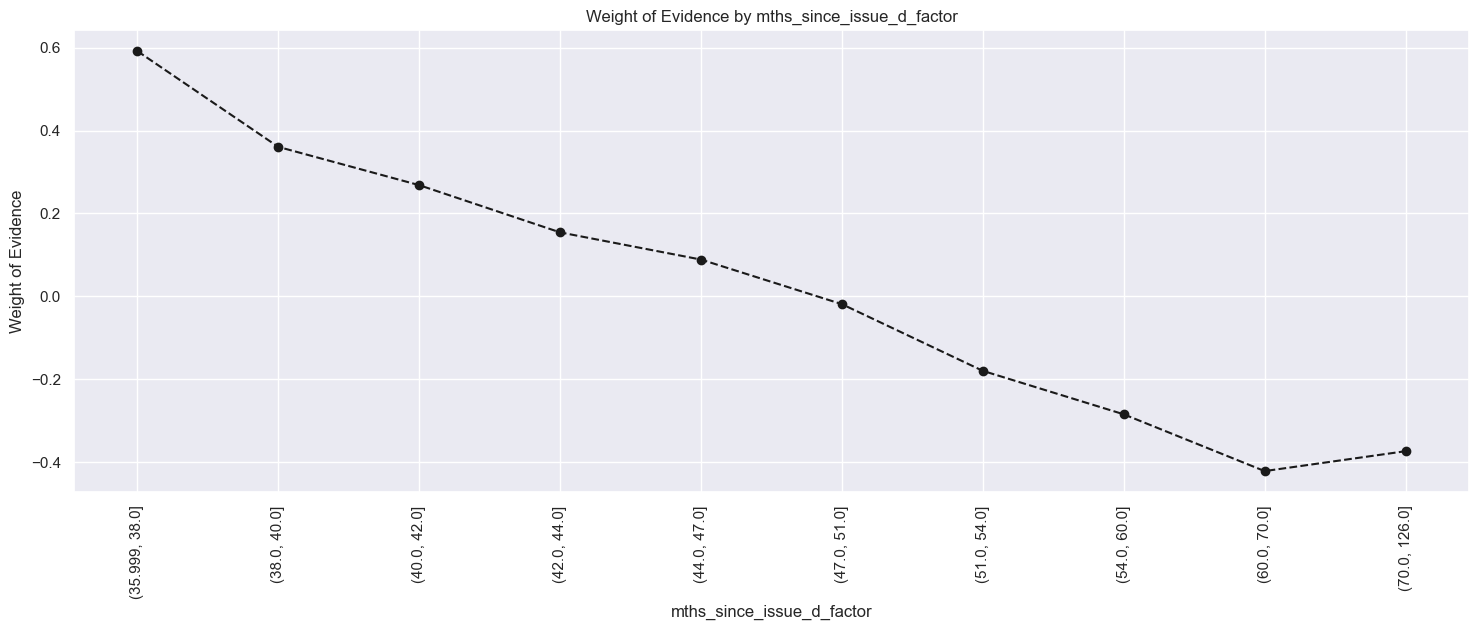

In [102]:
plot_by_woe(woe_continuous('mths_since_issue_d_factor'), 90)

In [103]:
mths_since_issue_d_factor_map = dict(zip(woe_continuous('mths_since_issue_d_factor')['mths_since_issue_d_factor'], woe_continuous('mths_since_issue_d_factor')['WoE']))
df['mths_since_issue_d_factor_WoE'] = df['mths_since_issue_d_factor'].map(mths_since_issue_d_factor_map)

<h3> Single Factor Selection </h3>

<p> Based on IV > 3% and sound credit intuition trend on WoE <strong>above</strong> </p>

<P> Discrete (Ordinal) Variables: grade  </P> 

<p> Continuous Variables: term_int, mths_since_issue_d_factor, int_rate_factor, annual_inc_factor, dti_factor, inq_last_6mths_factor, total_rev_hi_lim_factor </p>

In [104]:
#Encoding for ordinal variables
label_encoder = LabelEncoder()

df['grade_encoded'] = label_encoder.fit_transform(df['grade'])
# df['term_int_encoded'] = label_encoder.fit_transform(df['term_int'])

In [184]:
X = df[['grade_encoded','term_int', 'mths_since_issue_d', 'dti', 'int_rate', 'annual_inc', 'inq_last_6mths', 'total_rev_hi_lim']]
y = df['good_bad']

<h3> Logistic Regression Model w/o SMOTE and w/o WOE </h3>

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [107]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(X_train)
scaled_train_features_df = pd.DataFrame(scaled_train_features, index=X_train.index, columns=X_train.columns)
X_train = scaled_train_features_df

scaled_test_features = scaler.transform(X_test)
scaled_test_features_df = pd.DataFrame(scaled_test_features, index=X_test.index, columns=X_test.columns)
X_test = scaled_test_features_df

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

X_train = sm.add_constant(X_train)

model = sm.Logit(y_train, X_train)
trained_model = model.fit()

print(trained_model.summary())      

Optimization terminated successfully.
         Current function value: 0.323461
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               good_bad   No. Observations:               312390
Model:                          Logit   Df Residuals:                   312381
Method:                           MLE   Df Model:                            8
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                 0.06472
Time:                        00:59:53   Log-Likelihood:            -1.0105e+05
converged:                       True   LL-Null:                   -1.0804e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.2851      0.007   -339.892      0.000      -2.298      -2.272
grade

In [109]:
X_test_selected = sm.add_constant(X_test)
y_pred = trained_model.predict(X_test_selected)

In [110]:
results = pd.DataFrame()

results['predicted probabilities'] = y_pred
results['predicted'] = np.where(results['predicted probabilities'] >= 0.5, 1, 0)
results['actual outcome'] = y_test

results

,predicted probabilities,predicted,actual outcome
53955,0.084881,0,0
73769,0.093001,0,0
101802,0.173293,0,0
122556,0.058860,0,0
449065,0.121983,0,0
...,...,...,...
341294,0.204521,0,1
188347,0.178528,0,0
393885,0.120175,0,0
203888,0.087107,0,1


<h4> Model Performance - Log Reg w/o WoE w SMOTE </h4>

In [111]:
TN = results[(results['actual outcome'] == 0) & (results['predicted'] == 0)]
TP = results[(results['actual outcome'] == 1) & (results['predicted'] == 1)]
FN = results[(results['actual outcome'] == 0) & (results['predicted'] == 1)]
FP = results[(results['actual outcome'] == 1) & (results['predicted'] == 0)]

Confusion_List = []
TP_FP = [len(TP),len(FP)]
FN_TN = [len(FN),len(TN)]
Confusion_List.append(TP_FP)
Confusion_List.append(FN_TN)

Confusion_Matrix = pd.DataFrame(Confusion_List)
Confusion_Matrix.rename(columns = {0: 'Actual: 1', 1: "Actual: 0"}, inplace = True)
Confusion_Matrix.rename(index = {0: 'Predicted: 1', 1: "Predicted: 0"}, inplace = True)

Confusion_Matrix

,Actual: 1,Actual: 0
Predicted: 1,3,16699
Predicted: 0,6,137157


In [112]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [113]:
fpr, tpr, thresholds = roc_curve(results['actual outcome'], results['predicted probabilities'])
roc_auc = auc(fpr, tpr)

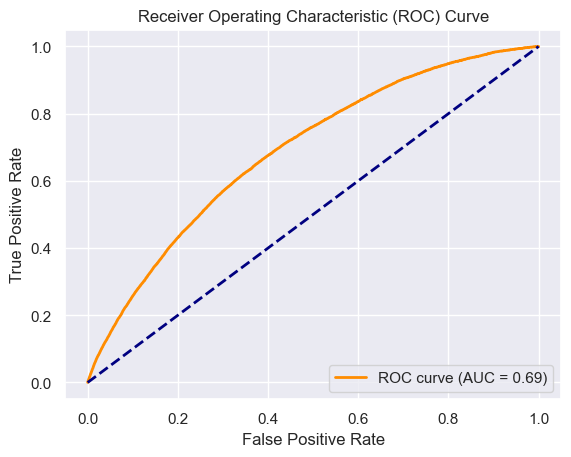

In [114]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [115]:
AUC_ROC = roc_auc_score(results['actual outcome'], results['predicted probabilities'])
print('AUC-ROC: ' + str(AUC_ROC))

AUC-ROC: 0.6889257445635388


In [116]:
gini_coefficient = 2 * roc_auc - 1
print('Gini Coef (AR): ' + str(gini_coefficient))

Gini Coef (AR): 0.37785148912707767


<h3> Logistic Regression Model w SMOTE and w/o WOE </h3>

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [118]:
# APPLY SMOTE TO MINORITY CLASS

y_train.value_counts()     #highly imbalanced on training dataset

0    278127
1     34263
Name: good_bad, dtype: int64

In [119]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

In [120]:
y_train.value_counts()     #balanced using KNN to generate synthetic minority class.

1    278127
0    278127
Name: good_bad, dtype: int64

In [121]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(X_train)
scaled_train_features_df = pd.DataFrame(scaled_train_features, index=X_train.index, columns=X_train.columns)
X_train = scaled_train_features_df

scaled_test_features = scaler.transform(X_test)
scaled_test_features_df = pd.DataFrame(scaled_test_features, index=X_test.index, columns=X_test.columns)
X_test = scaled_test_features_df

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

X_train = sm.add_constant(X_train)

model = sm.Logit(y_train, X_train)
trained_model = model.fit()

print(trained_model.summary())      

Optimization terminated successfully.
         Current function value: 0.563482
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               good_bad   No. Observations:               556254
Model:                          Logit   Df Residuals:                   556245
Method:                           MLE   Df Model:                            8
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  0.1871
Time:                        00:59:56   Log-Likelihood:            -3.1344e+05
converged:                       True   LL-Null:                   -3.8557e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0115      0.003     -3.744      0.000      -0.018      -0.005
grade

In [123]:
X_test_selected = sm.add_constant(X_test)
y_pred = trained_model.predict(X_test_selected)

In [124]:
results = pd.DataFrame()

results['predicted probabilities'] = y_pred
results['predicted'] = np.where(results['predicted probabilities'] >= 0.5, 1, 0)
results['actual outcome'] = y_test

results

,predicted probabilities,predicted,actual outcome
53955,0.639988,1,0
73769,0.428117,0,0
101802,0.512959,1,0
122556,0.140921,0,0
449065,0.322476,0,0
...,...,...,...
341294,0.555539,1,1
188347,0.735492,1,0
393885,0.280447,0,0
203888,0.392047,0,1


<h4> Model Performance - Log Reg w/o WoE w SMOTE </h4>

In [125]:
TN = results[(results['actual outcome'] == 0) & (results['predicted'] == 0)]
TP = results[(results['actual outcome'] == 1) & (results['predicted'] == 1)]
FN = results[(results['actual outcome'] == 0) & (results['predicted'] == 1)]
FP = results[(results['actual outcome'] == 1) & (results['predicted'] == 0)]

Confusion_List = []
TP_FP = [len(TP),len(FP)]
FN_TN = [len(FN),len(TN)]
Confusion_List.append(TP_FP)
Confusion_List.append(FN_TN)

Confusion_Matrix = pd.DataFrame(Confusion_List)
Confusion_Matrix.rename(columns = {0: 'Actual: 1', 1: "Actual: 0"}, inplace = True)
Confusion_Matrix.rename(index = {0: 'Predicted: 1', 1: "Predicted: 0"}, inplace = True)

Confusion_Matrix

,Actual: 1,Actual: 0
Predicted: 1,8412,8290
Predicted: 0,42187,94976


In [126]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [127]:
fpr, tpr, thresholds = roc_curve(results['actual outcome'], results['predicted probabilities'])
roc_auc = auc(fpr, tpr)

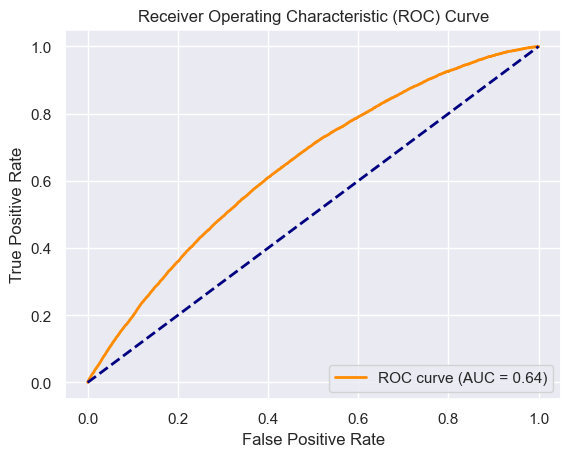

In [128]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [129]:
AUC_ROC = roc_auc_score(results['actual outcome'], results['predicted probabilities'])
print('AUC-ROC: ' + str(AUC_ROC))

AUC-ROC: 0.644334164236895


In [130]:
gini_coefficient = 2 * roc_auc - 1
print('Gini Coef (AR): ' + str(gini_coefficient))

Gini Coef (AR): 0.2886683284737901


<h3> Logistic Regression model with WoE as input values, no SMOTE applied</h3>

<p> *No need for standardscalar since using WoE as input values </p>

In [131]:
from sklearn.model_selection import train_test_split

X = df[['grade_WoE', 'purpose_WoE', 'int_rate_factor_WoE', 'annual_inc_factor_WoE', 'dti_factor_WoE', 'inq_last_6mths_factor_WoE', 'total_rev_hi_lim_factor_WoE', 'term_int_WoE', 'mths_since_issue_d_factor_WoE']]
y = df['good_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

X_train = sm.add_constant(X_train)

#fitting log reg model
model = sm.Logit(y_train, X_train)
trained_model = model.fit()

print(trained_model.summary())          #no variables with p-value greater than 0.05

Optimization terminated successfully.
         Current function value: 0.321541
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               good_bad   No. Observations:               279753
Model:                          Logit   Df Residuals:                   279743
Method:                           MLE   Df Model:                            9
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                 0.06946
Time:                        00:59:58   Log-Likelihood:                -89952.
converged:                       True   LL-Null:                       -96667.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.1016      0.006   -324.775      0.

In [133]:
X_test_selected = sm.add_constant(X_test)
y_pred = trained_model.predict(X_test_selected)

In [134]:
results = pd.DataFrame()
results['predicted probabilities'] = y_pred
results['predicted'] = np.where(results['predicted probabilities'] >= 0.5, 1, 0)
results['actual outcome'] = y_test

In [135]:
results

,predicted probabilities,predicted,actual outcome
53955,0.076542,0,0
73769,0.088281,0,0
101802,0.231173,0,0
122556,0.085528,0,0
449065,0.121951,0,0
...,...,...,...
317038,0.038746,0,0
423798,0.155980,0,0
95132,0.190351,0,0
103474,0.168542,0,0


<h4> Model Performance - Log Reg with WoE w/o SMOTE </h4>

In [136]:
TN = results[(results['actual outcome'] == 0) & (results['predicted'] == 0)]
TP = results[(results['actual outcome'] == 1) & (results['predicted'] == 1)]
FN = results[(results['actual outcome'] == 0) & (results['predicted'] == 1)]
FP = results[(results['actual outcome'] == 1) & (results['predicted'] == 0)]

Confusion_List = []
TP_FP = [len(TP),len(FP)]
FN_TN = [len(FN),len(TN)]
Confusion_List.append(TP_FP)
Confusion_List.append(FN_TN)

Confusion_Matrix = pd.DataFrame(Confusion_List)
Confusion_Matrix.rename(columns = {0: 'Actual: 1', 1: "Actual: 0"}, inplace = True)
Confusion_Matrix.rename(index = {0: 'Predicted: 1', 1: "Predicted: 0"}, inplace = True)

Confusion_Matrix

,Actual: 1,Actual: 0
Predicted: 1,4,20318
Predicted: 0,2,166178


In [137]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [138]:
fpr, tpr, thresholds = roc_curve(results['actual outcome'], results['predicted probabilities'])
roc_auc = auc(fpr, tpr)

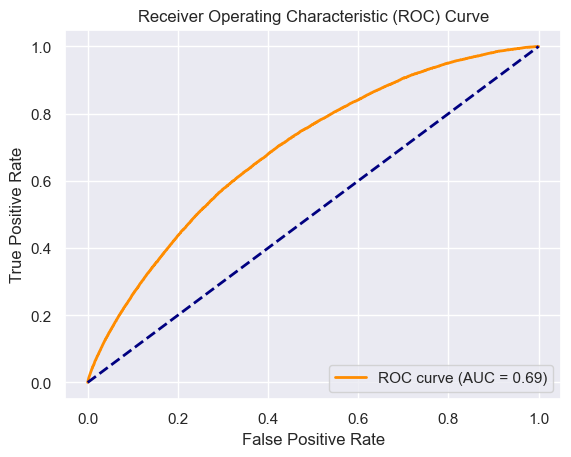

In [139]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [140]:
AUC_ROC = roc_auc_score(results['actual outcome'], results['predicted probabilities'])
print('AUC-ROC: ' + str(AUC_ROC))

AUC-ROC: 0.693200120140595


<h4> Gini and KS </h4>

In [141]:
gini_coefficient = 2 * roc_auc - 1
print('Gini Coef (AR): ' + str(gini_coefficient))

Gini Coef (AR): 0.3864002402811899


<h3> XGBoost w/o SMOTE and w/o WOE </h3>

In [197]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [198]:
y_test = y_test.reset_index().drop('index', axis = 1)

In [205]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

xgb_classifier.fit(X_train, y_train)

predictions = xgb_classifier.predict_proba(X_test)

In [208]:
results = pd.DataFrame()

results['predicted probabilities'] = predictions[:,1]
results['predicted'] = np.where(results['predicted probabilities'] >= 0.5, 1, 0)
results['actual outcome'] = y_test['good_bad']

results

,predicted probabilities,predicted,actual outcome
0,0.083046,0,0
1,0.074981,0,0
2,0.214512,0,0
3,0.107625,0,0
4,0.152097,0,0
...,...,...,...
153860,0.173000,0,1
153861,0.192622,0,0
153862,0.206734,0,0
153863,0.085168,0,1


<h4> Model Performance - Log Reg w/o WoE w SMOTE </h4>

In [209]:
TN = results[(results['actual outcome'] == 0) & (results['predicted'] == 0)]
TP = results[(results['actual outcome'] == 1) & (results['predicted'] == 1)]
FN = results[(results['actual outcome'] == 0) & (results['predicted'] == 1)]
FP = results[(results['actual outcome'] == 1) & (results['predicted'] == 0)]

Confusion_List = []
TP_FP = [len(TP),len(FP)]
FN_TN = [len(FN),len(TN)]
Confusion_List.append(TP_FP)
Confusion_List.append(FN_TN)

Confusion_Matrix = pd.DataFrame(Confusion_List)
Confusion_Matrix.rename(columns = {0: 'Actual: 1', 1: "Actual: 0"}, inplace = True)
Confusion_Matrix.rename(index = {0: 'Predicted: 1', 1: "Predicted: 0"}, inplace = True)

Confusion_Matrix

,Actual: 1,Actual: 0
Predicted: 1,76,16626
Predicted: 0,136,137027


In [210]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [211]:
fpr, tpr, thresholds = roc_curve(results['actual outcome'], results['predicted probabilities'])
roc_auc = auc(fpr, tpr)

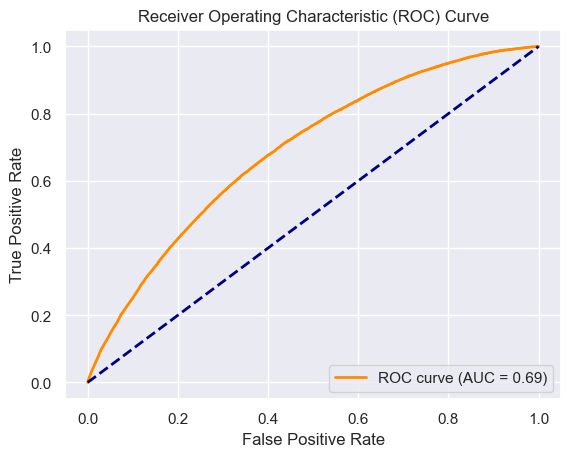

In [212]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [213]:
AUC_ROC = roc_auc_score(results['actual outcome'], results['predicted probabilities'])
print('AUC-ROC: ' + str(AUC_ROC))

AUC-ROC: 0.6896790038468548


In [214]:
gini_coefficient = 2 * roc_auc - 1
print('Gini Coef (AR): ' + str(gini_coefficient))

Gini Coef (AR): 0.37935800769370953
